# Tracking changes of individual chromosomes in time

In [1]:
# Ignore warnings in notebook
import warnings
warnings.filterwarnings('ignore')

# Some module needed in the notebook
import sys
import matplotlib as mpl
mpl.rcParams['animation.convert_path'] = 'magick'
# matplotlib.use('Agg')   
import matplotlib.cm as cm
import matplotlib.patches as patches
%matplotlib inline

# importing pandas package to manipulate data frames
import pandas as pd 
import numpy as np
#from itkwidgets import view
#import joblib
import copy
from scipy.signal import find_peaks
import scipy
import scipy.misc
import tifffile as tifff
from pylab import imshow, show
from skimage import measure, data, filters
from skimage.measure import label, regionprops, regionprops_table #need to update skimage for area to 0.16.1
import skimage as skimage
import cv2
import scipy
from scipy import spatial
from scipy.interpolate import splprep, splev

import matplotlib.pyplot as plt
import sklearn as sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression

import re, glob, csv, ast, os, copy
import math
from statistics import mean, variance, median, mode
from datetime import date as dateFun
import operator

import seaborn as sns
import napari
import h5py

from helpersLIN import*
from helpersLIN import traces



### Load necessary data

In [3]:
Btrace_ending="_btrois.csv"
outPath="./Results_AnasTracing_v2"
metadata_path="./20231211_Metadata_ChromosomeTracing.csv"
metadata_df=pd.read_csv(metadata_path,delimiter=",") #

path_correction="/g/koehler==Z:" 
nucID_splitter="|"
use_MD_spotmaxpath=False #if true uses spotmax results in the metadata table, otherwise is determines it based on the nucleus path

# Parameters - trace preprocessing 
no_spPoints=200 
smooth_factor=0.3 

# Parameters - sampling of equidistant points
no_spPoints_interparc=no_spPoints 
smooth_factor_to_sc= 0.3
interparc_spacing=0.1 #microns 
subselect=True # Subselects Points from the trace exported from BigTrace by perfoming DBSCAN Clustering and calculating mean for the final coordinate. Only done for "LineTrace" . For "Polyline" annotations it does not do anything.
subselect_eps=0.12 # DBSCAN parameter  #Details: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
interparc_method="CubicSpline" #Options:  PchipInterpolator Akima1DInterpolator CubicSpline
bc_type='not-a-knot' #Details: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html#scipy.interpolate.CubicSpline

# Parameters - thresholding (important for offset estimation between COSA-1 and SYP-4 channels)
background=None
threshold_mth="otsu" 
threshold_mth_cosa1="otsu" 
return_normalized_threshold=True
upper_quantile_cosa=0.95
upper_quantile_SC=0.95 
segm_ending="cp_masks_original" #Reads.tif file
cosa1Ch=633
sharpen_for_offsetcorr=True
sigma_sharpen=0.75
res_ZYX=[1, 3, 3]
estimate_res=True #If True res_ZYX is estimated from the emission wavelengths stored in metadata. Rayleigh: resolution_multiplier*1.22*lambda/(2*NA)
emissionWv_TR=None #If none, estimated from metadata
emissionWv_FC=670 #If none, estimated from metadata 
Z_limit_um=0.5 #If None, Z-increment is used
resolution_multiplier=1

# Parameters - offset calculation - main
offset_cal_on_gonad=True #If false, offset correction is done on cropped nucleus, otherwise on the entire gonad section imaged
gonad_segm_mask_ending="segm" #Reads.npy file - selects nuclei used for offset correction
use_gonad_orientation=True  #If true, line fitting of centroids (XY coords) of all the segmented objects specified by gonad_segm_mask_ending_orient is used to determine if ZY (abs(slope)>1) or ZX view is used to estimate offset along Z.
                            #If False, Z offset is calculated from on ZX view
gonad_segm_mask_ending_orient="segm_original" #Reads.npy file - selects nuclei on which the orientation of the gonad is calculated
export_offset_corrected=False

# Parameters - offset calculation - additional (options irrelevant for this study)
also_threshold_cropped=True
NPacc=0 
Z_buffer=0
save_path="./Results_AnasTracing_v2/" # If None, automatically determined
additional_ending="sameAs_231112"
axis="ZYX" 
round_offset=True # rounds to the higher intiger, std rounding, 0.5 to 0, 1.5 to 2, 2.5 to 2, -0.5 to 0, -1.5 to -2, -2.5 to -2,uses numpy.round
round_IC=True # Round to the higher absolute intiger 0.5 to 1, -0.5 to -1, 1.5 to 2 ...
display_Zoffsetcorrection=False 

# Additional parameters for optional ouput that is not a part of this study
empty_afit_fill=-0.000001 
straighten_traces=False
save_straightened=False
selection_um=0.33
axis_st=[0, 0, 1]
save_rois_as_csv=False
ending_processed_traces=""
shift_mode='grid-constant'
export_straight=["traced_image_analysisCh_corr","traced_image_analysisCh_trHold_corr"]
use_ssc=False
expand_mask_by=3 
sigma_blurCOSAmask=[2.5,1.5,1.5]

,GT1,GT2,SampleCode,Position,NucleiFolder,NucID_with_Btrois,SpotMaxFolder,SpotMaxRun,Num_spots,Date,Microscope,TracedChannel,405,488,546,647,PFA_Fixation%,Primary_Antibodies_Used_Dilution,Secondary_Antibodies_Used_Dilution,ELabJournal
0,syp-4::ha(ie29); halo::cosa-1 (ske25),WT,SampleA,1,/g/koehler/aneves/Data/Imaging/AiryScan/202209...,41|49|52|54,/g/koehler/aneves/Data/Imaging/AiryScan/202209...,3_2_spotfit_COSA-1.h5,6|6|6|6,01/09/2022,AiryScan880,561,DAPI,HTP-3,SYP-4::HA,HALOJF669,2 %,"1:500 Ck-a-HTP-3, 1:1250 Ms-anti-HA",1:500 Anti-Chicken Alexa Fluor 488-Conjugated ...,https://elabjournal.embl.de/members/experiment...
1,syp-4::ha(ie29); halo::cosa-1 (ske25),WT,SampleA,2,/g/koehler/aneves/Data/Imaging/AiryScan/202209...,43|51|74 |100,/g/koehler/aneves/Data/Imaging/AiryScan/202209...,3_2_spotfit_COSA-1.h5,6|6|6|7,01/09/2022,AiryScan880,561,DAPI,HTP-3,SYP-4::HA,HALOJF669,2 %,"1:500 Ck-a-HTP-3, 1:1250 Ms-anti-HA",1:500 Anti-Chicken Alexa Fluor 488-Conjugated ...,https://elabjournal.embl.de/members/experiment...
2,syp-4::ha(ie29); halo::cosa-1 (ske25),WT,SampleA,3,/g/koehler/aneves/Data/Imaging/AiryScan/202209...,36|38|63|79,/g/koehler/aneves/Data/Imaging/AiryScan/202209...,3_2_spotfit_COSA-1.h5,7|6|6|7,01/09/2022,AiryScan880,561,DAPI,HTP-3,SYP-4::HA,HALOJF669,2 %,"1:500 Ck-a-HTP-3, 1:1250 Ms-anti-HA",1:500 Anti-Chicken Alexa Fluor 488-Conjugated ...,https://elabjournal.embl.de/members/experiment...
3,syp-4(D114)::ha(ske19-2); halo::cosa-1 (ske25),D114(fromlet),SampleB,1,/g/koehler/aneves/Data/Imaging/AiryScan/202209...,53|73|87|101,/g/koehler/aneves/Data/Imaging/AiryScan/202209...,3_2_spotfit_COSA-1.h5,8|8|6|8,01/09/2022,AiryScan880,561,DAPI,HTP-3,SYP-4::HA,HALOJF669,2 %,"1:500 Ck-a-HTP-3, 1:1250 Ms-anti-HA",1:500 Anti-Chicken Alexa Fluor 488-Conjugated ...,https://elabjournal.embl.de/members/experiment...
4,syp-4(D114)::ha(ske19-2); halo::cosa-1 (ske25),D114(fromlet),SampleB,2,/g/koehler/aneves/Data/Imaging/AiryScan/202209...,32|34|44|48|69,/g/koehler/aneves/Data/Imaging/AiryScan/202209...,3_2_spotfit_COSA-1.h5,5|8|6|6|8,01/09/2022,AiryScan880,561,DAPI,HTP-3,SYP-4::HA,HALOJF669,2 %,"1:500 Ck-a-HTP-3, 1:1250 Ms-anti-HA",1:500 Anti-Chicken Alexa Fluor 488-Conjugated ...,https://elabjournal.embl.de/members/experiment...


In [ ]:
metadata_df.head(5)

In [4]:
if not sharpen_for_offsetcorr:
    estimate_res=False 

NucCollection={"Expanded_SC_mask": [],"SC_mask": [], "Threshold": [],"Threshold_foci": [], "Position": [], "Cell_ID": [],
               "path": [], "NucleiFolder":[], "rois":[], 'Voxel_XYZ': [],'offset_zyx':[],
               'traced_ch':[],"foci_ch":[],"foci_ch_uncorrected":[]}

initiate=True
if straighten_traces:
    chromosomes=dict()
    
if axis!="ZYX":
    print("Order of .tiff axis has to be ZYX, other options are not available. Code needs to be adjusted - correlation part for the channel offset correction, spotmax foci coordinate adjustment, transformation of traces to um, and maybe more.")
    sys.exit(34)
    
for row in range(len(metadata_df)):
    
    #Control for row with nan values in the path columns
    if (len(str(metadata_df.NucleiFolder[row]))<1) or (len(str(metadata_df.TracedChannel[row]))<1) :
        print("Due to missing info, skipping metadata row : "+str(row))
        continue

    gonad_path=metadata_df.NucleiFolder[row].replace(path_correction.split("==")[0], path_correction.split("==")[1]).strip(" ")
    if gonad_path[-1]=="/":
        gonad_path=gonad_path[:-1]

    spotmaxrun=metadata_df.SpotMaxRun[row]
    sypChannel=metadata_df.TracedChannel[row]
    if spotmaxrun[-3:]!=".h5":
        spotmaxrun=spotmaxrun+".h5"
    if use_MD_spotmaxpath:
        h5File=metadata_df.SpotMaxFolder[row].replace(path_correction.split("==")[0], path_correction.split("==")[1])+"/"+str(spotmaxrun)
    else:
        h5File=glob.glob(os.path.dirname(gonad_path)+"/spotMAX_output")[0]+"/"+str(spotmaxrun)
    
    if len(h5File)==0:
        sys.exit("Error: Spotmax file not found.")
    if offset_cal_on_gonad:
        gonad_images=glob.glob(os.path.dirname(gonad_path)+"/Images")[0]
        if estimate_res:
            gonad_traced_ch, res_ZYX=traces.get_sharpening_input(glob.glob(gonad_images+"/*"+str(int(sypChannel))+".tif")[0],
                                                                 Z_limit_um=Z_limit_um,resolution_multiplier=resolution_multiplier,emission=emissionWv_TR)
        else:
            gonad_traced_ch=tifff.imread(glob.glob(gonad_images+"/*"+str(int(sypChannel))+".tif"))
        
        cellpose_segm=np.load(glob.glob(gonad_images+"/*"+gonad_segm_mask_ending+".npy")[0])
        gonad_traced_ch=traces.threshold_mine(gonad_traced_ch,mask=cellpose_segm,id=0,threshold_mth=threshold_mth,binary_output=False,
                                              preThresh=background,return_normalized=return_normalized_threshold,upper_quantile=upper_quantile_SC,
                                              sharpen_prior=sharpen_for_offsetcorr,sharpen_sigma=sigma_sharpen,sigma_res=res_ZYX)
        
        if estimate_res:
            gonad_foci_ch, res_ZYX=traces.get_sharpening_input(glob.glob(gonad_images+"/*"+str(int(cosa1Ch))+".tif")[0],
                                                               Z_limit_um=Z_limit_um,resolution_multiplier=resolution_multiplier,emission=emissionWv_FC)
        else:
            gonad_foci_ch=tifff.imread(glob.glob(gonad_images+"/*"+str(int(cosa1Ch))+".tif"))

        gonad_foci_ch=traces.threshold_mine(gonad_foci_ch,mask=cellpose_segm,id=0,threshold_mth=threshold_mth_cosa1,binary_output=False,
                                            preThresh=background,return_normalized=return_normalized_threshold,upper_quantile=upper_quantile_cosa,
                                            sharpen_prior=sharpen_for_offsetcorr,sharpen_sigma=sigma_sharpen,sigma_res=res_ZYX)
                                            
        
        corrYX=scipy.signal.correlate(np.amax(gonad_traced_ch,axis.index("Z")),np.amax(gonad_foci_ch,axis.index("Z")),mode="same",method="auto")
        corrZY=scipy.signal.correlate(np.amax(gonad_traced_ch,axis.index("X")),np.amax(gonad_foci_ch,axis.index("X")),mode="same",method="auto")
        corrZX=scipy.signal.correlate(np.amax(gonad_traced_ch,axis.index("Y")),np.amax(gonad_foci_ch,axis.index("Y")),mode="same",method="auto")
        correctionYX=np.unravel_index(np.argmax(corrYX), np.shape(corrYX), order='C')-np.array(np.array(np.amax(gonad_traced_ch,axis.index("Z")).shape).astype("double")*(1/2))
        correctionZY=np.unravel_index(np.argmax(corrZY), np.shape(corrZY), order='C')-np.array(np.array(np.amax(gonad_traced_ch,axis.index("X")).shape).astype("double")*(1/2))
        correctionZX=np.unravel_index(np.argmax(corrZX), np.shape(corrZX), order='C')-np.array(np.array(np.amax(gonad_traced_ch,axis.index("Y")).shape).astype("double")*(1/2))
        
        if use_gonad_orientation:
            cellpose_segm_orient=np.load(glob.glob(gonad_images+"/*"+gonad_segm_mask_ending_orient+".npy")[0])
            props = regionprops_table(cellpose_segm_orient, properties=('centroid','label'))
            x=props["centroid-2"]-mean(props["centroid-2"])
            y=props["centroid-1"]-mean(props["centroid-1"])
            print("Gonad orientation is determined by linear regression.")
            model = LinearRegression().fit(x.reshape((-1, 1)), y.reshape((-1, 1)))
            r_sq = model.score(x.reshape((-1, 1)), y.reshape((-1, 1)))
            if (abs(np.round(model.coef_,1))>1 and use_gonad_orientation):
                use_zy=True
                print("ZY view is used to determine z-offset of cosa-1 channel.")
            else:
                use_zy=False
                print("ZX view is used to determine z-offset of cosa-1 channel.")
        else:
            use_zy=False
            print("Z offset is estimated on ZX view, gonad orientation was not estimated.")
    
    for nucleus in metadata_df.NucID_with_Btrois.values[row].split(nucID_splitter):
        nucleus=nucleus.strip(" ") 
        path=glob.glob(gonad_path+"/nuc"+(nucleus)+"/*"+Btrace_ending) [0]
        print(path)   

        cell_ID=traces.get_INTsubfolder_order(path,numberingPattern="nucleus[0-9]+")[0]
        if str(cell_ID)!=str(nucleus):
            print("Error: check that the correct nucleus ID is placed within the metadara row: "+str(row))
            print(cell_ID)
            sys.exit(6311)
        position=traces.get_INTsubfolder_order(path,numberingPattern="Position_[0-9]+")[0]
        
        if offset_cal_on_gonad:
            return_normalized_threshold_2=False
        else:
            return_normalized_threshold_2=return_normalized_threshold
        if estimate_res and (also_threshold_cropped or (not offset_cal_on_gonad)):
            traced_image, res_ZYX=traces.get_sharpening_input(glob.glob(os.path.dirname(path)+"/*_"+str(int(sypChannel))+"*_nucleus"+str(cell_ID)+".tif")[0],
                                                              Z_limit_um=Z_limit_um,resolution_multiplier=resolution_multiplier,emission=emissionWv_TR)
        else:
            traced_image=tifff.imread(glob.glob(os.path.dirname(path)+"/*_"+str(int(sypChannel))+"*_nucleus"+str(cell_ID)+".tif"))
        segmentation_Arr=np.zeros(np.shape(traced_image))
        traced_image_segm=tifff.imread(glob.glob(os.path.dirname(path)+"/*_"+segm_ending+"*_nucleus"+str(cell_ID)+".tif"))
        
        

        traced_image_trHold=traces.threshold_mine(traced_image,mask=traced_image_segm,id=cell_ID,threshold_mth=threshold_mth,binary_output=False,
                                                  preThresh=background,return_normalized=return_normalized_threshold_2,upper_quantile=upper_quantile_SC,
                                                  sharpen_prior=sharpen_for_offsetcorr,sharpen_sigma=sigma_sharpen,sigma_res=res_ZYX)
        
        if estimate_res and (also_threshold_cropped or (not offset_cal_on_gonad)):
            traced_image_analysisCh, res_ZYX=traces.get_sharpening_input(glob.glob(os.path.dirname(path)+"/*_"+str(cosa1Ch)+"*_nucleus"+str(cell_ID)+".tif")[0],
                                                                         Z_limit_um=Z_limit_um,resolution_multiplier=resolution_multiplier,emission=emissionWv_FC)
        else:
            traced_image_analysisCh=tifff.imread(glob.glob(os.path.dirname(path)+"/*_"+str(cosa1Ch)+"*_nucleus"+str(cell_ID)+".tif"))

        traced_image_analysisCh_trHold=traces.threshold_mine(traced_image_analysisCh,mask=traced_image_segm,id=cell_ID,threshold_mth=threshold_mth_cosa1,binary_output=False,
                                                             preThresh=background,return_normalized=return_normalized_threshold_2,upper_quantile=upper_quantile_cosa,
                                                             sharpen_prior=sharpen_for_offsetcorr,sharpen_sigma=sigma_sharpen,sigma_res=res_ZYX)
        if offset_cal_on_gonad:
            if use_zy:
                correction=[correctionZY[0],correctionYX[0],correctionYX[1]]
            else:
                correction=[correctionZX[0],correctionYX[0],correctionYX[1]] 
           
        else:
            corr=scipy.signal.correlate(traced_image_trHold,traced_image_analysisCh_trHold,mode="same",method="auto")
            correction=np.unravel_index(np.argmax(corr), np.shape(corr), order='C')-np.array(np.array(traced_image.shape).astype("double")*(1/2))
        
        if sum([abs(ax)>10 for ax in correction])>0:
            print("Warning: some correction seems unrealistic!!")

        correction=np.array(correction)
        if round_offset:
            if round_IC:
                correction[correction>0]=np.ceil(correction[correction>0])
                correction[correction<0]=np.floor(correction[correction<0])
            else:
                correction=np.round(correction)
            
        # print("Round to:")
        print(correction)
        
        #Read in BigTrace traces for current position folder
        rois, genericinfo, Voxel=traces.get_rois_IC(path)
        transform=np.diag(Voxel)
        inverse_transform=np.diag([1/axis for axis in Voxel])
        transform_ZYX=np.diag(Voxel[::-1])
        inverse_transform_ZYX=np.diag([1/axis for axis in Voxel[::-1]])
        #read metadata that contains original bounding box values...
        with tifff.TiffFile(glob.glob(os.path.dirname(path)+"/*_"+str(int(sypChannel))+"*_nucleus"+str(cell_ID)+".tif")[0]) as tif:
            meta = tif.imagej_metadata
        info_dct = dict((a[0].strip(), a[1].strip())  
                                for a in (re.split('=|:',element)  
                                            for element in meta["Info"].split(',') if '=' in element or ':' in element))

        
        if not str(info_dct["label"])==str(cell_ID):
            if not str(info_dct["label"])==str(float(cell_ID)):
                sys.exit(111)
        traced_image_analysisCh_corr=scipy.ndimage.shift(traced_image_analysisCh,correction.astype("int"),order=0,mode="grid-constant").astype(np.uint16)
        if offset_cal_on_gonad and (not also_threshold_cropped):
            if return_normalized_threshold:
                factor=10**(np.floor(math.log10(2^int(16))))
            else:
                factor=1
            traced_image_analysisCh_trHold=np.copy(gonad_foci_ch[min(int(float(info_dct["bbox-0"])),int(float(info_dct["bbox-3"])))-Z_buffer:max(int(float(info_dct["bbox-0"])),int(float(info_dct["bbox-3"])))+Z_buffer+NPacc,
                                                                    min(int(float(info_dct["bbox-1"])),int(float(info_dct["bbox-4"]))):max(int(float(info_dct["bbox-1"])),int(float(info_dct["bbox-4"])))+NPacc,
                                                                    min(int(float(info_dct["bbox-2"])),int(float(info_dct["bbox-5"]))):max(int(float(info_dct["bbox-2"])),int(float(info_dct["bbox-5"])))+NPacc])*factor
            if traced_image_analysisCh_trHold.shape!=traced_image.shape:
                print("Warning: when recropping nucleus from sharpened gonad, final shape was not the same as in the traced nucleus!. Problematic because trace is not adjusted to this. fix cropping here to fit what was done previously (+NPacc nad Z_buffer)")
            traced_image_trHold=np.copy(gonad_traced_ch[min(int(float(info_dct["bbox-0"])),int(float(info_dct["bbox-3"])))-Z_buffer:max(int(float(info_dct["bbox-0"])),int(float(info_dct["bbox-3"])))+Z_buffer+NPacc,
                                                                    min(int(float(info_dct["bbox-1"])),int(float(info_dct["bbox-4"]))):max(int(float(info_dct["bbox-1"])),int(float(info_dct["bbox-4"])))+NPacc,
                                                                    min(int(float(info_dct["bbox-2"])),int(float(info_dct["bbox-5"]))):max(int(float(info_dct["bbox-2"])),int(float(info_dct["bbox-5"])))+NPacc])*factor
        
        traced_image_analysisCh_trHold_corr=scipy.ndimage.shift(traced_image_analysisCh_trHold,correction.astype("int"),order=0,mode='constant').astype(np.uint16)
        
        if export_offset_corrected:
            with tifff.TiffFile(glob.glob(os.path.dirname(path)+"/*_"+str(cosa1Ch)+"*_nucleus"+str(cell_ID)+".tif")[0]) as tif:
                foci_meta = tif.imagej_metadata
           
            save_as=glob.glob(os.path.dirname(path)+"/*_"+str(cosa1Ch)+"*_nucleus"+str(cell_ID)+".tif")[0][:-4]+"_offset"+additional_ending+".tif"
            pxSch=Voxel[0]
            tifff.imwrite(save_as,traced_image_analysisCh_corr,dtype='uint16', imagej=True,metadata=foci_meta,resolution=(1/pxSch,1/pxSch))
        

        if initiate:
            bbox={key: [val] for key, val in info_dct.items() if "bbox" in key}
            bbox["offset_z"]=[correction[0]]
            bbox["offset_y"]=[correction[1]]
            bbox["offset_x"]=[correction[2]]
            bbox["Position"]=[position]
            bbox["Cell_ID"]=[cell_ID]
            bbox["path"]=[path]
            if use_gonad_orientation:
                bbox["gonad_orientation_slope"]=[model.coef_]
                bbox["gonad_orientation_intercept"]=[model.intercept_]
                bbox["gonad_orientation_r_sq"]=[r_sq]
                bbox["gonad_orientation_use_zy"]=[use_zy]
                # bbox["gonad_orientation_mask"]=[gonad_segm_mask_ending_orient]
            dat_allT = pd.read_hdf(h5File)
            dat_allT=dat_allT.reset_index()
            dat_allT=dat_allT[dat_allT["Cell_ID"]==cell_ID]
            dat_allT=dat_allT.reset_index(drop=True)
            dat_allT["num_spots"]=len(dat_allT)
            dat_allT["path"]=path
            dat_allT["NucleiFolder"]=metadata_df.NucleiFolder[row]
            initiate=False
        else:
            for key, val in info_dct.items():
                if key in bbox:
                    bbox[key].append(val) 
            bbox["Position"].append(position)
            bbox["Cell_ID"].append(cell_ID)
            bbox["offset_z"].append(correction[0])
            bbox["offset_y"].append(correction[1])
            bbox["offset_x"].append(correction[2])
            bbox["path"].append(path)
            if use_gonad_orientation:
                bbox["gonad_orientation_slope"].append(model.coef_)
                bbox["gonad_orientation_intercept"].append(model.intercept_)
                bbox["gonad_orientation_r_sq"].append(r_sq)
                bbox["gonad_orientation_use_zy"].append(use_zy)
                # bbox["gonad_orientation_mask"].append(gonad_segm_mask_ending_orient)
            temp= pd.read_hdf(h5File)
            temp=temp.reset_index()
            temp=temp[temp["Cell_ID"]==cell_ID]
            temp["path"]=path
            temp["NucleiFolder"]=metadata_df.NucleiFolder[row]
            temp=temp.reset_index(drop=True)
            temp["num_spots"]=len(temp)
            dat_allT=pd.concat([dat_allT,temp])
        # Loop through rois(traces of the current nucleus)            
        firstone=True
        for roi in rois:
            mask_value=int(roi["Order"][0])
            points=np.matmul(roi["Points"][:,0:3],transform)
            tck, u = splprep(np.transpose(points).tolist(), s=smooth_factor)
            if no_spPoints is not None:
                spline_points = splev(np.linspace(0,1,no_spPoints), tck)
            else:
                spline_points = splev(np.linspace(0,1,np.shape(points)[0]), tck)
            roi["Spline_um"]=np.transpose(spline_points) #
            roi["splprep_output"]=copy.copy(tck) #
            roi["Points_um"]=np.copy(points)
            roi["Spline"]=np.matmul(np.transpose(spline_points),inverse_transform).astype(np.int16)
            roi["Arclength_um"]=traces.arclength_simple(np.transpose(spline_points))
            roi["SC"]=int(roi["Order"][0])
            roi["Name_ROI"]=roi["Name"][0]
            roi["Cell_ID"]=cell_ID
            px_spline=np.matmul(np.transpose(spline_points),np.diag([1/axis for axis in Voxel])).astype(np.int16)
            px_spline_uniqueReordered = px_spline[:,[2,1,0]]
            nth, uniq_idx = np.unique(px_spline_uniqueReordered, return_index=True,axis=0)
            roi["Spline_unique_ZYX"]=np.copy(px_spline_uniqueReordered[np.sort(uniq_idx),:])
            r_spl=np.transpose(spline_points)[:,[2,1,0]]
            nth, uniq_idx = np.unique(r_spl, return_index=True,axis=0)
            roi["Spline_unique_ZYX_um"]=np.copy( r_spl[np.sort(uniq_idx),:])
            for index in range(np.shape(px_spline_uniqueReordered)[0]):
                segmentation_Arr[tuple(px_spline_uniqueReordered[index,:])]=mask_value
            if subselect and roi["Type"][0]=="linetrace":
                clustering =  DBSCAN(eps=subselect_eps,min_samples=1, algorithm="brute",metric="minkowski",p=5).fit(points)

                df=pd.DataFrame(np.c_[points,clustering.labels_],columns=["X","Y","Z","cluster"])
                summary=df.groupby(["cluster"],as_index=False).agg(X = ('X', 'mean'),Y = ('Y', 'mean'),Z = ('Z', 'mean'))
                points=np.array(summary[["X","Y","Z"]].values)
            
            roi["Points_um_subselect"]=np.copy(points)
            tck, u = splprep(np.transpose(points[:,[2,1,0]]).tolist(), s=smooth_factor_to_sc)
            if no_spPoints_interparc is not None:
                spline_points = splev(np.linspace(0,1,no_spPoints_interparc), tck)
            else:
                spline_points = splev(np.linspace(0,1,int(roi["Arclength_um"]/interparc_spacing)), tck)
            roi["Spline_SC_um"]=np.transpose(spline_points) #
            interparc_output=traces.interparc(int(roi["Arclength_um"]/interparc_spacing),np.transpose(spline_points),method=interparc_method,bc_type=bc_type)
            roi["interparc_ZYX_um"]=interparc_output 
            roi["TNB_frame"]=traces.TNB_frame_splines(roi["interparc_ZYX_um"]["pt"],method=interparc_method,bc_type=bc_type)
            unit_tangent=roi["interparc_ZYX_um"]["dudt"]/np.linalg.norm(roi["interparc_ZYX_um"]["dudt"],axis=1)[:,None]
            angle=[np.arccos(np.dot(unit_tangent[i,:],[1,0,0])) for i in range(np.shape(unit_tangent)[0])]
            roi["interparc_ZYX_um_Unit_tangent"]=unit_tangent
            roi["interparc_ZYX_um_angleuT-Z"]=angle
            pt_ZYX_px=np.matmul(roi["interparc_ZYX_um"]["pt"],inverse_transform_ZYX).astype('int')
            nth, uniq_idx = np.unique(pt_ZYX_px, return_index=True,axis=0)
            pt_ZYX_px=np.copy(pt_ZYX_px[np.sort(uniq_idx),:])
            roi["pt_ZYX_px"]=np.copy(pt_ZYX_px)
            roi["path"]=path
            roi["interparc_arclength_um"]=np.copy(interparc_output["arclength"][0])
            if straighten_traces:
                selection_radius=selection_um/Voxel[0]
                if estimate_res:
                    selection_radius=res_ZYX[2]*1.5
                iso_inverse_transform_ZYX=np.copy(inverse_transform_ZYX)
                iso_inverse_transform_ZYX[0,0]=iso_inverse_transform_ZYX[1,1]
                aniso=np.copy(traced_image)
                SC_mask=np.zeros(np.shape(aniso))
                output_shape=np.shape(aniso)
                output_shape=[int(output_shape[0]*Voxel[2]/Voxel[0]),output_shape[1],output_shape[2]]
                for index in range(np.shape(pt_ZYX_px)[0]):
                    SC_mask[tuple(pt_ZYX_px.astype("int")[index,:])]=1
                SC_mask_iso=skimage.transform.resize(SC_mask, output_shape=output_shape, order=0, mode='constant', cval=1.0, clip=True, preserve_range=False, anti_aliasing=False, anti_aliasing_sigma=None)
                iso=skimage.transform.resize(aniso, output_shape=output_shape, order=0, mode='reflect', clip=True, preserve_range=False, anti_aliasing=False, anti_aliasing_sigma=None)
                iso_add=dict()
                for SandE in export_straight:
                    iso_add[SandE]=eval("skimage.transform.resize("+SandE+", output_shape=output_shape, order=0, mode='reflect', clip=True, preserve_range=False, anti_aliasing=False, anti_aliasing_sigma=None)")

                SC_mask_iso=skimage.segmentation.expand_labels(SC_mask_iso, distance=selection_radius)
                points=np.argwhere(SC_mask_iso==1)
                newpoints, finin = traces.straightener_3D(points, iso_inverse_transform_ZYX, interparc_output,Voxel,selection_radius,interparc_spacing, axis_st,use_ssc=use_ssc,overhang_factor=overhang_factor)

                newpointsINT=newpoints[np.where(finin)[0],:]-np.amin(newpoints[np.where(finin)[0],:],0)
                pointsINT=points[np.where(finin)[0],:]
                straight=np.zeros(np.insert(np.amax(newpointsINT,0)+1, 0, 1+len(export_straight), axis=None)) #CZYX
                for index in range(np.shape(newpointsINT)[0]):
                    straight[tuple(np.insert(newpointsINT.astype("int")[index,:], 0, 0, axis=None))]=iso[tuple(pointsINT.astype("int")[index,:])]
                    for se, SandE in enumerate(export_straight):
                        straight[tuple(np.insert(newpointsINT.astype("int")[index,:], 0, 1+se, axis=None))]=iso_add[SandE][tuple(pointsINT.astype("int")[index,:])]
                # leftout=points[np.where(finin==False)[0],:]
                # portion_leftout=(len(finin)-sum(finin))/len(finin)
                
                if save_rois_as_csv:
                    # nth, uniq_idx = np.unique(pt_ZYX_px, return_index=True,axis=0)
                    # pt_ZYX_px=np.copy(pt_ZYX_px[np.sort(uniq_idx),:])
                    if firstone:
                        traces_forSimone={"ROI": [roi["Name"][0]]*np.shape(pt_ZYX_px)[0], 'Z': pt_ZYX_px[:,0], 'Y': pt_ZYX_px[:,1], 'X': pt_ZYX_px[:,2]}
                    else:
                        traces_forSimone["ROI"]=np.concatenate((traces_forSimone["ROI"], [roi["Name"][0]]*np.shape(pt_ZYX_px)[0]))
                        traces_forSimone["Z"]=np.concatenate((traces_forSimone["Z"], pt_ZYX_px[:,0]))
                        traces_forSimone["Y"]=np.concatenate((traces_forSimone["Y"], pt_ZYX_px[:,1]))
                        traces_forSimone["X"]=np.concatenate((traces_forSimone["X"], pt_ZYX_px[:,2]))

                if firstone:
                    chromosomes[path]=dict()
                    chromosomes[path][roi["Name"][0].lower()]=straight
                else:
                    chromosomes[path][roi["Name"][0].lower()]=straight             
            firstone=False
        if save_rois_as_csv:
            savein_traces_forSimone=os.path.dirname(path)+"/processed_traces"+ending_processed_traces+".csv"
            traces_forSimone=pd.DataFrame(traces_forSimone)
            traces_forSimone.to_csv(savein_traces_forSimone)
        if save_straightened:
            if save_path is None:
                save_path=os.path.dirname(path)+'/3D_straightener/'
            else:
                save_path=save_path+"/3D_straightener/nuc"+str(nucleus)+"_mdrow_"+str(row)+"/"
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            for trc in chromosomes[path].keys():
                tempST=np.expand_dims(chromosomes[path][trc],0)
                tempST=np.transpose(tempST, axes=[0, 2, 1, 3,4])
                tifff.imwrite(save_path+'MAX_'+str(trc)+'.tif',np.amax(tempST,axis=1).astype("uint16"),dtype='uint16',imagej=True,metadata={"axes": "TCYX"},resolution=(1/Voxel[0],1/Voxel[0]))
        expand_segmentation_arr=skimage.segmentation.expand_labels(segmentation_Arr, distance=expand_mask_by)
        NucCollection["Expanded_SC_mask"].append(expand_segmentation_arr)
        NucCollection["SC_mask"].append(segmentation_Arr)
        NucCollection['Threshold'].append(traced_image_trHold)
        NucCollection['Threshold_foci'].append(traced_image_analysisCh_trHold)#_corr
        NucCollection['traced_ch'].append(traced_image)
        NucCollection['foci_ch'].append(traced_image_analysisCh_corr)
        NucCollection['foci_ch_uncorrected'].append(traced_image_analysisCh)
        NucCollection['Position'].append(position)
        NucCollection['path'].append(path)
        NucCollection['NucleiFolder'].append(metadata_df.NucleiFolder[row])
        NucCollection['Cell_ID'].append(cell_ID)
        NucCollection['rois'].append(rois)
        NucCollection['Voxel_XYZ'].append(Voxel)
        NucCollection['offset_zyx'].append(correction)
        
    if display_Zoffsetcorrection:
        ax=1
        if use_zy: ax=2
        display_ax=np.array(range(len(gonad_foci_ch.shape)))[np.array(range(len(gonad_foci_ch.shape)))!=ax]
        size_factor=2
        aspects=[1,Voxel[2]/Voxel[0],Voxel[2]/Voxel[0]] 
        plt.figure(figsize=(size_factor*gonad_foci_ch.shape[max(display_ax)]/100, size_factor*gonad_foci_ch.shape[min(display_ax)]/100))
        plt.imshow(np.amax(gonad_traced_ch, axis=ax), cmap='Reds', alpha =1,aspect=aspects[ax])
        plt.imshow(np.amax(gonad_foci_ch, axis=ax), cmap='Greens', alpha = 0.8,aspect=aspects[ax])
        plt.colorbar()
        plt.show()

        print("Corrected:")
        plt.figure(figsize=(size_factor*gonad_foci_ch.shape[max(display_ax)]/100, size_factor*gonad_foci_ch.shape[min(display_ax)]/100))
        plt.imshow(np.amax(gonad_traced_ch, axis=ax), cmap='Reds', alpha =1,aspect=aspects[ax])
        plt.imshow(np.amax(scipy.ndimage.shift(gonad_foci_ch,correction.astype("int"),order=0,mode="grid-constant"), axis=ax), cmap='Greens', alpha = 0.8,aspect=aspects[ax])
        plt.colorbar() 
        plt.show()


df_bbox=pd.DataFrame.from_dict(bbox)
for col in df_bbox.columns:
    if "bbox" in col:
        df_bbox[[col]]=df_bbox[[col]].apply(pd.to_numeric)
dat_allT=pd.merge(dat_allT.reset_index(drop=True), metadata_df,how='left', on = ['NucleiFolder'],suffixes=["","_metadata"])
dat_allT=pd.merge(dat_allT.reset_index(drop=True), df_bbox,how='left', on = ["path"],suffixes=["","_imageinfo"])

dat_allT["z_adjust_bbox"]=dat_allT.z-dat_allT[["bbox-0","bbox-3"]].min(axis=1)
dat_allT["y_adjust_bbox"]=dat_allT.y-dat_allT[["bbox-1","bbox-4"]].min(axis=1)
dat_allT["x_adjust_bbox"]=dat_allT.x-dat_allT[["bbox-2","bbox-5"]].min(axis=1)
dat_allT["z_adjust_offset"]=dat_allT.z_adjust_bbox+dat_allT["offset_z"]
dat_allT["y_adjust_offset"]=dat_allT.y_adjust_bbox+dat_allT["offset_y"]
dat_allT["x_adjust_offset"]=dat_allT.x_adjust_bbox+dat_allT["offset_x"]
        

Gonad orientation is determined by linear regression.
ZX view is used to determine z-offset of cosa-1 channel.
Z:/aneves/Data/Imaging/AiryScan/20220901_ie29_halo-cosa-1-D114_halo-cosa-1_AN90_halo-cosa-1_DAPI_CkHTP3A488_MsHAA546_HALO669/SampleA/TIFFs/Position_1/nuclei/nuc41\SampleA_Gonad1_Airyscan_Processing_561___nucleus41_8bit.tif_btrois.csv
[-1. -1.  1.]
Z:/aneves/Data/Imaging/AiryScan/20220901_ie29_halo-cosa-1-D114_halo-cosa-1_AN90_halo-cosa-1_DAPI_CkHTP3A488_MsHAA546_HALO669/SampleA/TIFFs/Position_1/nuclei/nuc49\SampleA_Gonad1_Airyscan_Processing_561___nucleus49_8bit.tif_btrois.csv
[-1. -1.  1.]
Z:/aneves/Data/Imaging/AiryScan/20220901_ie29_halo-cosa-1-D114_halo-cosa-1_AN90_halo-cosa-1_DAPI_CkHTP3A488_MsHAA546_HALO669/SampleA/TIFFs/Position_1/nuclei/nuc52\SampleA_Gonad1_Airyscan_Processing_561___nucleus52_8bit.tif_btrois.csv
[-1. -1.  1.]
Z:/aneves/Data/Imaging/AiryScan/20220901_ie29_halo-cosa-1-D114_halo-cosa-1_AN90_halo-cosa-1_DAPI_CkHTP3A488_MsHAA546_HALO669/SampleA/TIFFs/Positi

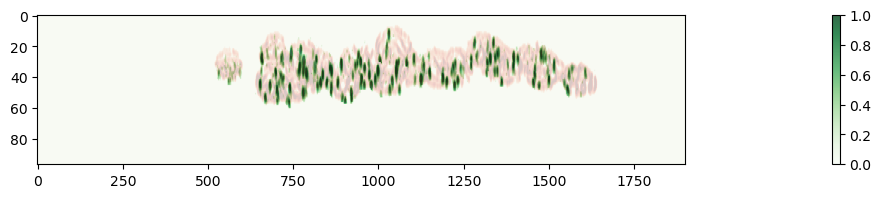

Corrected:


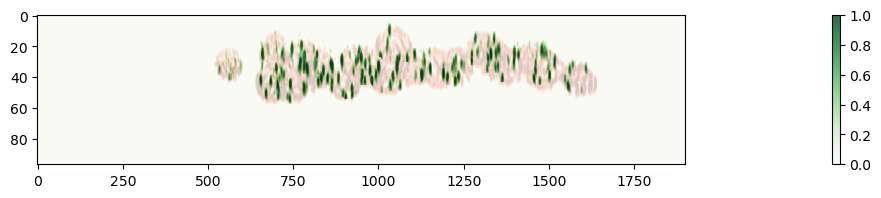

In [5]:
ax=1
display_ax=np.array(range(len(gonad_foci_ch.shape)))[np.array(range(len(gonad_foci_ch.shape)))!=ax]
size_factor=2
aspects=[1,Voxel[2]/Voxel[0],Voxel[2]/Voxel[0]] #aspects of yX, ZY, and ZX view
plt.figure(figsize=(size_factor*gonad_foci_ch.shape[max(display_ax)]/100, size_factor*gonad_foci_ch.shape[min(display_ax)]/100))
plt.imshow(np.amax(gonad_traced_ch, axis=ax), cmap='Reds', alpha =1,aspect=aspects[ax])
plt.imshow(np.amax(gonad_foci_ch, axis=ax), cmap='Greens', alpha = 0.8,aspect=aspects[ax])
plt.colorbar()
plt.show()

print("Corrected:")
plt.figure(figsize=(size_factor*gonad_foci_ch.shape[max(display_ax)]/100, size_factor*gonad_foci_ch.shape[min(display_ax)]/100))
plt.imshow(np.amax(gonad_traced_ch, axis=ax), cmap='Reds', alpha =1,aspect=aspects[ax])
plt.imshow(np.amax(scipy.ndimage.shift(gonad_foci_ch,correction.astype("int"),order=0,mode="grid-constant"), axis=ax), cmap='Greens', alpha = 0.8,aspect=aspects[ax])
plt.colorbar() #correction.astype("int") prevents interpolation. order=1?
plt.show()

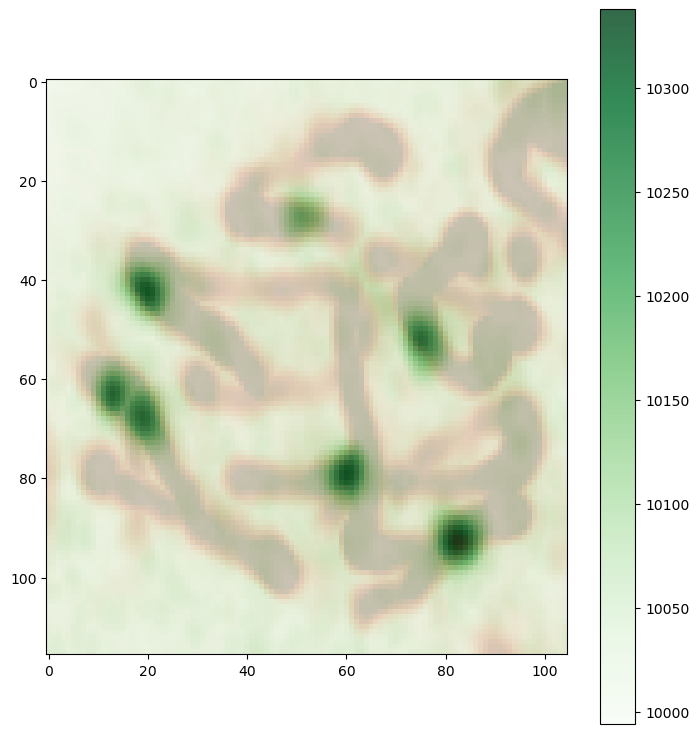

Corrected:


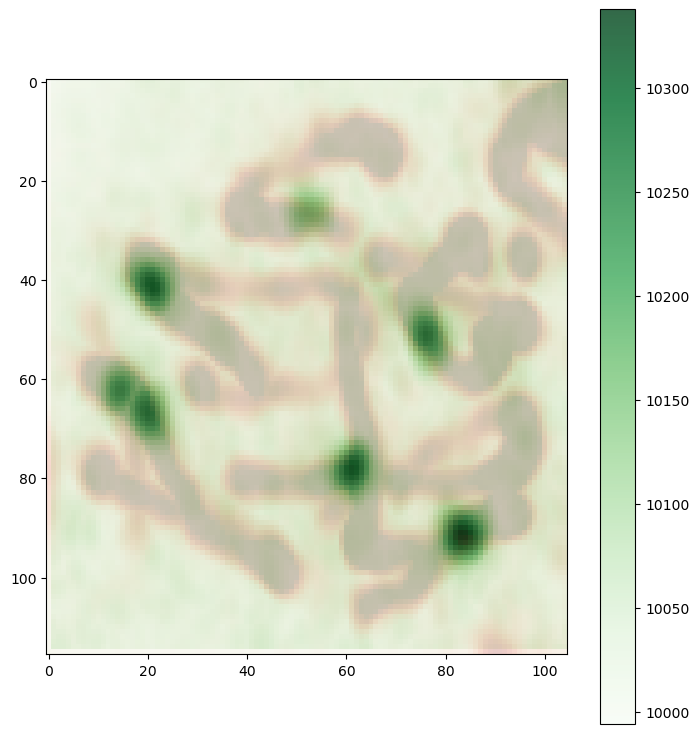

In [6]:
nuc2display=0 
ax=0
display_ax=np.array(range(len( NucCollection['traced_ch'][nuc2display].shape)))[np.array(range(len( NucCollection['traced_ch'][nuc2display].shape)))!=ax]
size_factor=2
aspects=[1,Voxel[2]/Voxel[0],Voxel[2]/Voxel[0]]
plt.figure(figsize=(size_factor* NucCollection['traced_ch'][nuc2display].shape[max(display_ax)]/25, size_factor* NucCollection['traced_ch'][nuc2display].shape[min(display_ax)]/25))
plt.imshow(np.amax(NucCollection['traced_ch'][nuc2display], axis=ax), cmap='Reds', alpha =1,aspect=aspects[ax],vmin=np.quantile(NucCollection['traced_ch'][nuc2display],0.05),vmax=np.quantile(NucCollection['traced_ch'][nuc2display],0.98))
plt.imshow(np.amax(NucCollection['foci_ch_uncorrected'][nuc2display], axis=ax), cmap='Greens', alpha = 0.8,aspect=aspects[ax],vmin=np.min(NucCollection['foci_ch_uncorrected'][nuc2display]),vmax=np.max(NucCollection['foci_ch_uncorrected'][nuc2display]))
plt.colorbar()
plt.show()

print("Corrected:")
plt.figure(figsize=(size_factor* NucCollection['traced_ch'][nuc2display].shape[max(display_ax)]/25, size_factor* NucCollection['traced_ch'][nuc2display].shape[min(display_ax)]/25))
plt.imshow(np.amax(NucCollection['traced_ch'][nuc2display], axis=ax), cmap='Reds', alpha =1,aspect=aspects[ax],vmin=np.quantile(NucCollection['traced_ch'][nuc2display],0.05),vmax=np.quantile(NucCollection['traced_ch'][nuc2display],0.98))
plt.imshow(np.amax(NucCollection['foci_ch'][nuc2display], axis=ax), cmap='Greens', alpha = 0.8,aspect=aspects[ax],vmin=np.min(NucCollection['foci_ch_uncorrected'][nuc2display]),vmax=np.max(NucCollection['foci_ch_uncorrected'][nuc2display]))
plt.colorbar()
plt.show()

In [7]:
initiate=True
for idx, btroipath in enumerate(NucCollection["path"]):

    count=0
    for roi in NucCollection["rois"][idx]:
        SCProperties={"PositionOnSC_um": [],"Curvature": [], "Torsion": [], "Position": [], "path": [], "Cell_ID": [], "SC": [], "Name_ROI": [], "arclength": [],"Z": [],"Y": [], "X": [],"Zangle":[]}
        helper=len(roi["interparc_ZYX_um"]["t"])
                
        SCProperties["PositionOnSC_um"]=np.concatenate((SCProperties["PositionOnSC_um"], roi["interparc_ZYX_um"]["t"]*roi["interparc_ZYX_um"]["arclength"]))
        SCProperties["Curvature"]=np.concatenate((SCProperties["Curvature"],roi["TNB_frame"]["curvature"]))
        SCProperties["Torsion"]=np.concatenate((SCProperties["Torsion"],roi["TNB_frame"]["torsion"]))
        SCProperties["Zangle"]=np.concatenate((SCProperties["Zangle"],roi["interparc_ZYX_um_angleuT-Z"]))
    
        pts=roi["interparc_ZYX_um"]["pt"]
        # print(pts)
        SCProperties["Z"]=np.concatenate((SCProperties["Z"],pts[:,0]))
        SCProperties["Y"]=np.concatenate((SCProperties["Y"],pts[:,1]))
        SCProperties["X"]=np.concatenate((SCProperties["X"],pts[:,2]))
        SCProperties["SC"]=np.concatenate((SCProperties["SC"],[roi["Order"][0]] * helper))
        # SCProperties["path_roi"]=np.concatenate((SCProperties["path"],[roi["path"]] * helper))
        SCProperties["Name_ROI"]=np.concatenate((SCProperties["Name_ROI"],[roi["Name"][0]] * helper))
        SCProperties["arclength"]=np.concatenate((SCProperties["arclength"],[roi["interparc_ZYX_um"]["arclength"][0]] * helper))
        unwanted_keys = ["Cell_ID","Position","path"] # The keys you want
        NucCollection["rois"][idx][count]["SCProperties"]=dict((k, SCProperties[k]) for k in SCProperties.keys() if k not in unwanted_keys)
        count+=1
    # helper2=len(SCProperties["Curvature"])
        SCProperties["path"]=np.copy([btroipath] * helper)
        SCProperties["Position"]=np.copy([NucCollection["Position"][idx]] * helper)
        SCProperties["Cell_ID"]=np.copy([NucCollection["Cell_ID"][idx]] * helper)
    
        if initiate:
            SCProperties_all=pd.DataFrame.from_dict(SCProperties)
            initiate=False
        else:
            SCProperties_all=pd.concat([SCProperties_all,pd.DataFrame.from_dict(SCProperties)])

SCProperties_all=SCProperties_all.reset_index(drop=True)

del SCProperties

In [8]:

#Parameters for the confidence of the association to the certain location of the chromosome
window_um=0.5 
top_hits=int(2*(window_um/interparc_spacing)) 
tol_factor=1



COSA1Collection={"COSA1_pxl_mask": [], "COSA1_blurred_mask": []}
COSA1association={"Position": [],"path": [], "spot_id": [], "Cell_ID": [], "SC": [],"PositionOnSC_pxl": [],"Positionbypointnumber": [], "SC_by_pxl_d":[],
                  "PositionOnSC_um": [],"Curvature": [],"file_n":[],"distance2SC_um":[],"distance2SC_pxl":[],"trace_name":[],
                  "SC_secP":[],"distance2SC_um_secP":[],"PositionOnSC_um_secP": [],
                  "SC_secC":[],"distance2SC_um_secC":[],"PositionOnSC_um_secC": [],
                  "conf_of_loc_2":[],"conf_of_loc_1":[],"conf_of_loc":[],"conf_of_SC_1":[],"window_um":[],"top_hits":[],"tol_factor":[],"Arclength_associated": []}
cosa1_coordinates_PD=dat_allT[["z_adjust_bbox","z_adjust_offset","y_adjust_offset","x_adjust_offset","y_adjust_bbox","x_adjust_bbox","path","Position","spot_id","Cell_ID"]].reset_index(drop=True)


for idx, btroipath in enumerate(NucCollection["path"]):
    segmentation_ArrC=np.zeros(np.shape(NucCollection["Expanded_SC_mask"][idx]))
    cosa1_ArrC=np.zeros(np.shape(NucCollection["Expanded_SC_mask"][idx]))
    current_foci=cosa1_coordinates_PD[cosa1_coordinates_PD["path"]==btroipath].reset_index(drop=True)
    current_rois=NucCollection["rois"][idx]
    Voxel=NucCollection["Voxel_XYZ"][idx]
    transform_ZYX=np.diag(Voxel[::-1])
    mask_shape=np.shape(segmentation_ArrC)

    for row in current_foci.index:
        current_splines=traces.extract_array_field_allROIs("Spline_unique_ZYX",current_rois,keepROIOrder=True)
        SCPropertiesCombo=traces.combine_pandasfield_from_allROIs(current_rois,'["SCProperties"]',fullname=True)
        forcal=SCPropertiesCombo[["Z","Y","X","PositionOnSC_um", "SC","Curvature","trace_name",'arclength']].values
        
        focus_coord=current_foci.loc[row,["z_adjust_offset","y_adjust_offset","x_adjust_offset"]].values.astype("float")
        
        #Associate to the original spline (200 points closly along the original trace)
        distances=[np.linalg.norm(focus_coord-current_splines[point,0:3]) for point in range(np.shape(current_splines)[0]) ] 
        min_index = distances.index(min(distances)) 
        assosiate_to=current_splines[min_index,3]
        position_along_SC=int(current_splines[min_index,4])
        current_splines_um=traces.extract_array_field_allROIs("Spline_unique_ZYX_um",current_rois,keepROIOrder=True)
        current_splines_um=current_splines_um[current_splines_um[:,3]==assosiate_to,0:3]
        arcL_to_end1=0
        if position_along_SC!=0:
            for i in range(position_along_SC):
                d=np.linalg.norm(current_splines_um[i,:] - current_splines_um[i-1,:])
                arcL_to_end1 +=d
        
        #Preferd distance and association calculation: using equidistantly spaced points sampled along the spline
        distances2=[np.linalg.norm(np.matmul(focus_coord,transform_ZYX,dtype="longdouble")-forcal[point,0:3]) for point in range(np.shape(forcal)[0]) ]      
        min_index2 = distances2.index(min(distances2))
        
        assosiate_to2=int(forcal[min_index2,4])
        
        position_along_SC2=forcal[min_index2,3]
        #seond closest point
        secP_index2 = distances2.index(sorted(distances2)[1])
        secP_assosiate_to2=int(forcal[secP_index2,4])
        position_along_SC2_secP=forcal[secP_index2,3]
        d_selected_to_secP=np.linalg.norm(forcal[min_index2,0:3] - forcal[secP_index2,0:3])
        
        #calculate how reliable the locus association is
        ##measure_1
        forcal_selC=forcal[forcal[:,4]==forcal[min_index2,4],:] #rewrite - this is unecessary, all needed info is in distances2 already
        distances2_selC=[np.linalg.norm(np.matmul(focus_coord,transform_ZYX,dtype="longdouble")-forcal_selC[point,0:3]) for point in range(np.shape(forcal_selC)[0]) ]
        
        bins=np.append(np.arange(min(forcal_selC[:,3]),forcal_selC[distances2_selC.index(min(distances2_selC)),3]-window_um/2,window_um),np.arange(forcal_selC[distances2_selC.index(min(distances2_selC)),3]+window_um/2,max(forcal_selC[:,3]),window_um))
        bin_assign=np.digitize(forcal_selC[:,3], bins=bins)
        closest_points=bin_assign[np.argsort(distances2_selC)[0:min(top_hits,len(distances2_selC))]]
        bin,bin_count=np.unique(closest_points, return_counts=True)
        top_bin=bin_assign[distances2_selC.index(min(distances2_selC))]
        top_bin_count=bin_count[bin==top_bin][0]

        if sum(closest_points[closest_points!=top_bin])==0:
            conf_of_loc_1=top_hits#/sum(bin_assign==top_bin)
        else:
            bin_s,bin_count_s=np.unique(closest_points[closest_points!=top_bin], return_counts=True)
            s_bin=bin_s[np.argmax(bin_count_s)]
            s_bin_count=bin_count_s[np.argmax(bin_count_s)]

            conf_of_loc_1=(top_hits-((top_hits-top_bin_count)*(abs(bins[top_bin-1]-bins[s_bin-1])/abs(bins[0]-bins[-1])))) #(top_bin_count)*mean(np.array(distances2_selC)[bin_assign==s_bin]))/(mean(np.array(distances2_selC)[bin_assign==top_bin])
        
        ##measure_2 and second closest SC
        # Is=list(range(len(distances2_selC)))
        # Is=[i for i in Is if i!=int(distances2_selC.index(min(distances2_selC)))]
        # conf_of_loc_2=sum((np.array(distances2_selC)[Is]/min(distances2_selC))/(abs(forcal_selC[Is,3]-forcal_selC[distances2_selC.index(min(distances2_selC)),3])/interparc_spacing))/len(Is)
        
        sorted_distances=np.array(distances2)[np.argsort(distances2)]
        sorted_SCs=forcal[np.argsort(distances2),4]
        sorted_distances_alongSCs=forcal[np.argsort(distances2),3]
        # sorted_distances_associatedSC=sorted_distances[forcal[np.argsort(distances2),4]==forcal[min_index2,4]]
        expected=window_um/interparc_spacing
        
        n_associated=np.where(sorted_SCs!=forcal[min_index2,4])[0][0] # Number of first points tat were associated to the same SC, also index of the first distance that belongs to another chromosome
        #Alternative parameter exported as conf_of_SC_1
        conf_of_SC=(n_associated/(expected*tol_factor))*(sorted_distances[n_associated]/np.array(distances2)[np.argmin(distances2)])
        
        position_along_SC2_secC=sorted_distances_alongSCs[n_associated]    
        d_to_secC=sorted_distances[n_associated]    
        secC_assosiate_to2=sorted_SCs[n_associated]

        arranged_pos_along=sorted_distances_alongSCs[forcal[np.argsort(distances2),4]==forcal[min_index2,4]]
        sorted_distances_assSC=sorted_distances[forcal[np.argsort(distances2),4]==forcal[min_index2,4]]
        
        dist_to_sel_along=abs(arranged_pos_along[1:]-arranged_pos_along[0])
        diif_toa_ass=abs(dist_to_sel_along)>window_um
        n_within=np.where(diif_toa_ass==True)[0][0]
        #Simone's suggestion modified
        conf_of_loc_2=(n_within/expected)*((dist_to_sel_along[n_within-1]+interparc_spacing)/dist_to_sel_along[np.where(diif_toa_ass==True)[0][0]])#*(sorted_distances_assSC[np.where(diif_toa_ass==True)[0][0]+1]/distances2[min_index2])
        #Simone's suggestion
        conf_of_loc=n_within 

        #Save association in the dictionary to add to the dat_all table later
        COSA1association["path"].append(btroipath)
        COSA1association["file_n"].append(idx)
        COSA1association["Position"].append(np.copy(NucCollection["Position"][idx]))
        COSA1association["spot_id"].append(current_foci.loc[row,["spot_id"]].values[0])
        COSA1association["Cell_ID"].append(current_foci.loc[row,["Cell_ID"]].values[0])
        COSA1association["SC_by_pxl_d"].append(assosiate_to)
        COSA1association["PositionOnSC_pxl"].append(arcL_to_end1)
        COSA1association["Positionbypointnumber"].append(position_along_SC)
        COSA1association["SC"].append(assosiate_to2)
        COSA1association["trace_name"].append(forcal[min_index2,6])
        COSA1association["distance2SC_um"].append(distances2[min_index2])
        COSA1association["distance2SC_pxl"].append(distances[min_index])
        COSA1association["PositionOnSC_um"].append(position_along_SC2)
        COSA1association["Curvature"].append(forcal[min_index2,5])
        COSA1association["Arclength_associated"].append(forcal[min_index2,7])
        COSA1association["PositionOnSC_um_secP"].append(position_along_SC2_secP)
        COSA1association["distance2SC_um_secP"].append(distances2[secP_index2])
        COSA1association["SC_secP"].append(secP_assosiate_to2)
        COSA1association["PositionOnSC_um_secC"].append(position_along_SC2_secC)
        COSA1association["distance2SC_um_secC"].append(d_to_secC)
        COSA1association["SC_secC"].append(secC_assosiate_to2)
        COSA1association["conf_of_loc_1"].append(conf_of_loc_1)
        COSA1association["conf_of_loc_2"].append(conf_of_loc_2)
        COSA1association["conf_of_loc"].append(conf_of_loc)
        COSA1association["conf_of_SC_1"].append(conf_of_SC)
        COSA1association["window_um"].append(window_um)
        COSA1association["top_hits"].append(top_hits)
        COSA1association["tol_factor"].append(tol_factor)

        if sum([crd<0 for crd in focus_coord] )>0:
            print("WARNING: focus coordinate is negative, likely due to offset correction. Recreation of mask won't work.")
        segmentation_ArrC[int(min(focus_coord[0],mask_shape[0]-1)),int(min(focus_coord[1],mask_shape[1]-1)),int(min(focus_coord[2],mask_shape[2]-1))]=assosiate_to2
        cosa1_ArrC[int(min(focus_coord[0],mask_shape[0]-1)),int(min(focus_coord[1],mask_shape[1]-1)),int(min(focus_coord[2],mask_shape[2]-1))]=1


    COSA1Collection["COSA1_pxl_mask"].append(skimage.segmentation.expand_labels(np.copy(segmentation_ArrC),distance=expand_mask_by))
    COSA1Collection["COSA1_blurred_mask"].append(scipy.ndimage.gaussian_filter(cosa1_ArrC,sigma=sigma_blurCOSAmask))

df_cosa1=pd.DataFrame(COSA1association)
df_cosa1["Cell_ID"] = df_cosa1["Cell_ID"] .astype('int')
df_cosa1["spot_id"] = df_cosa1["spot_id"] .astype('int')
df_cosa1["Position"] = df_cosa1["Position"] .astype('int')
df_cosa1["secP_on_same_SC"] = df_cosa1["SC_secP"].values==df_cosa1["SC"].values


#Calculate how confident the association to the SC is and normalize confidence values
df_cosa1["conf_of_SC"] = np.where(df_cosa1["secP_on_same_SC"], df_cosa1["distance2SC_um_secC"].values/df_cosa1["distance2SC_um"].values, df_cosa1["distance2SC_um_secC"].values/df_cosa1["distance2SC_um"].values)#
for variable in df_cosa1.columns[["conf_" in column for column in df_cosa1.columns]]:
    df_cosa1[variable+"_norm"]=df_cosa1[variable]/max(df_cosa1[variable])


df_cosa_1_full=pd.merge(df_cosa1, dat_allT.reset_index(drop=True),how='left', on = ['path','Position','Cell_ID',"spot_id"])

df_fociCount=pd.DataFrame(COSA1association)
df_fociCount["Position"] = df_fociCount["Position"] .astype('int')
df_fociCount=df_fociCount.groupby(['path','Position', 'Cell_ID',"SC"]).size().reset_index(name='counts')
# df_fociCount=pd.DataFrame(COSA1association).groupby(['AdjPosition','Position', 'Cell_ID',"SC"]).size().reset_index(name='counts')

initiate=True
for idx, btroipath in enumerate(NucCollection["path"]):
    current_rois=NucCollection["rois"][idx]
    for roi in current_rois:
        temp={key: roi[key] for key in roi.keys() & {'Name', 'Arclength_um', "SC","Cell_ID","interparc_arclength_um"}}
        temp["path"]=btroipath
        temp["Position"]=NucCollection["Position"][idx]
        if initiate:
            df_roistat=pd.DataFrame(temp)
            initiate=False
        else:
            df_roistat=pd.concat([df_roistat,pd.DataFrame(temp)])


df_roistat=df_roistat.reset_index(drop=True)

df_roistat=pd.merge(df_roistat, df_fociCount.reset_index(drop=True),how='left', on = ['path',"Position",'Cell_ID',"SC"])
df_roistat['Arclength_um'] = df_roistat['Arclength_um'].fillna(0)
df_roistat['counts'] = df_roistat['counts'].fillna(0)


SCProperties_all["PositionOnSC_norm"]=SCProperties_all.PositionOnSC_um/SCProperties_all.arclength
SCProperties_all["SC"]=SCProperties_all["SC"].values.astype("float")
SCProperties_all["NucleiFolder"]=[p.replace(path_correction.split("==")[1], path_correction.split("==")[0]).split('/nuclei')[0]+"/nuclei" for p in SCProperties_all["path"].values]
SCProperties_all=pd.merge(SCProperties_all,metadata_df,how="left",on=["NucleiFolder"], suffixes=["","_metadata_df"])

df_full=pd.merge(SCProperties_all, df_cosa_1_full.reset_index(drop=True),how='left', on = ['path',"Position",'Cell_ID',"SC","PositionOnSC_um"],suffixes=["_props",""])
df_full["A_fit"] = df_full["A_fit"].fillna(empty_afit_fill)
kymos=pd.merge(SCProperties_all, df_cosa_1_full.reset_index(drop=True),how='right', on = ['path',"Position",'Cell_ID',"SC","PositionOnSC_um"])



In [9]:
save_output=True
begin_filename="_spotmax_v2_offsetAdjusted_"

now=dateFun.today()
dt_string = now.strftime("%Y%m%d")
df_roistat["NucleiFolder"]=[p.replace(path_correction.split("==")[1], path_correction.split("==")[0]).split('/nuclei')[0]+"/nuclei" for p in df_roistat["path"].values]
df_roistat=pd.merge(df_roistat,metadata_df,how="left",on=["NucleiFolder"], suffixes=["","_metadata_df"])

if begin_filename[0]!="_":
    begin_filename="_"+begin_filename

if save_output:
    df_roistat.to_csv(outPath+"/"+dt_string+begin_filename+"_"+additional_ending+'_perTrace_summary.csv') #interparc_arclength_um
    df_cosa_1_full.to_csv(outPath+"/"+dt_string+begin_filename+"_"+additional_ending+'_perFoci_summary.csv') # Arclength_associated should be equivalent to the other in respective tables
    SCProperties_all.to_csv(outPath+"/"+dt_string+begin_filename+"_"+additional_ending+'_processedTraces.csv') #arclength
ivana_col_main=[   "#007e82",  "#6DA945",  "#E1E100",  "#E18A33"  , "#B21217"] #"#00FFFF", second to last , 
ivana_col_reduced=["#007e82",  "#E1E100",  "#B21217"]
ivana_col_inner=[   "#00FFFF",  "#E1E100",  "#E10000"]
ivana_col_outer=["#007e82",  "#E18A33"  , "#B21217"]

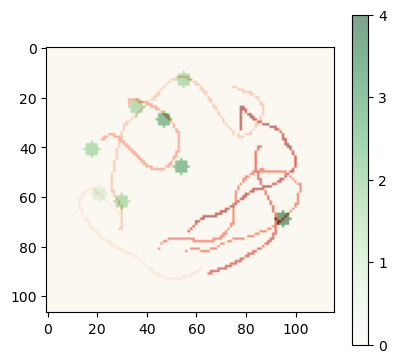

In [10]:
from matplotlib import colors
cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.arange(0, 7, 1), cmap.N)

plt.figure(figsize=(traced_image_analysisCh.shape[2]/25,traced_image_analysisCh.shape[1]/25))
plt.imshow(np.amax(NucCollection["SC_mask"][len(COSA1Collection['COSA1_pxl_mask'])-1], axis=0), cmap="Reds", alpha = 1)#,norm=norm
plt.imshow(np.amax(COSA1Collection['COSA1_pxl_mask'][len(COSA1Collection['COSA1_pxl_mask'])-1], axis=0), cmap='Greens', alpha = .5)
plt.colorbar(ticks=np.linspace(0, 6, 7))
plt.show()

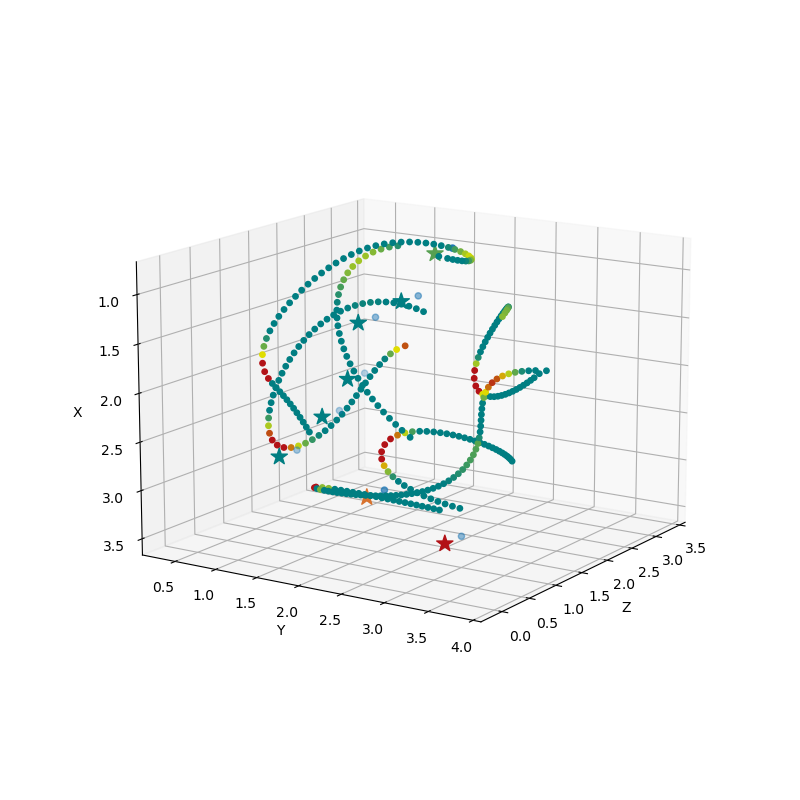

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
%matplotlib widget
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
PostoPlot=58
choose_path="Z:/aneves/Data/Imaging/AiryScan/20220901_ie29_halo-cosa-1-D114_halo-cosa-1_AN90_halo-cosa-1_DAPI_CkHTP3A488_MsHAA546_HALO669/SampleC/TIFFs/Position_1/nuclei/nuc58\\SampleC_Gonad1_Airyscan_Processing_561___nucleus58_8bit.tif_btrois.csv" #full path to the btroi file (needed if there is more then 1 nucleus with this cell ID) just copy it from the output of the first cell of code
SCProperties_plot=SCProperties_all[SCProperties_all["Cell_ID"]==PostoPlot]
df_cosa_1_full_plot=df_cosa_1_full[df_cosa_1_full["Cell_ID"]==PostoPlot]
if len(np.unique(SCProperties_plot["path"]))>1:
    if choose_path not in np.unique(SCProperties_plot["path"]):
        print("More than 1 nucleus with chosen cell_ID. Choose one path, assign it to the choose_path variable and rerun the cell")
        print(np.unique(SCProperties_plot["path"]))
    SCProperties_plot=SCProperties_plot[SCProperties_plot["path"]==choose_path]
    df_cosa_1_full_plot=df_cosa_1_full_plot[df_cosa_1_full_plot["path"]==choose_path]
    
cosa1col="SC"
ql=0
qu=1
transform_zyx=np.diag(Voxel[::-1])
vmin, vmax = np.quantile(SCProperties_plot["SC"],0.01), np.quantile(SCProperties_plot["Curvature"],0.95)#min(SCProperties_plot["Zangle"]),max(SCProperties_plot["Zangle"])#

colourby=SCProperties_plot["Curvature"]
colourby_afit=df_cosa_1_full_plot[cosa1col]
cmap = sns.blend_palette(ivana_col_reduced, n_colors=len(np.unique(colourby)), as_cmap=True, input='rgb')#sns.diverging_palette(220, 10,s=99, l=39,sep=6, center="dark", as_cmap=True)#choose_diverging_palette(as_cmap=False)#
ivana_invert=["#ff00ff","#00ffff"]
ivana_SCs=["#00FF00","#00FFFF","#0000FF","#FF00FF","#800080","#FF6700"]
if cosa1col=="A_fit":
    cmap_afit = sns.blend_palette(ivana_invert, n_colors=len(np.unique(colourby_afit)), as_cmap=True, input='rgb')#
else:
    cmap_afit = sns.blend_palette(ivana_col_main, n_colors=len(np.unique(colourby_afit)), as_cmap=True, input='rgb')#sns.set_palette(sns.color_palette(ivana_SCs, n_colors=6, as_cmap=True))#
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')#fig.gca(projection='3d')#
for i in np.unique(SCProperties_all["SC"]):
    plot=SCProperties_plot[SCProperties_plot["SC"]==i]
    colourby=plot["Curvature"]
    ax.scatter(*np.transpose(plot[["Z","Y","X"]].values), c=colourby, alpha=1, s=15, vmin=vmin, vmax=vmax, cmap=cmap)
vmin, vmax = np.quantile(df_cosa_1_full_plot[cosa1col],ql), np.quantile(df_cosa_1_full_plot[cosa1col],qu)
# df_cosa_1_full_plot["z_adjust"]=df_cosa_1_full_plot["z_adjust"]+1
# df_cosa_1_full_plot["y_adjust"]=df_cosa_1_full_plot["y_adjust"]-4
# df_cosa_1_full_plot["x_adjust"]=df_cosa_1_full_plot["x_adjust"]-1
#
ax.scatter(*np.transpose(np.matmul(df_cosa_1_full_plot[["z_adjust_offset","y_adjust_offset","x_adjust_offset"]].values,transform_zyx)), c=colourby_afit, alpha=1, s=150, vmin=vmin, vmax=vmax, cmap=cmap_afit,marker="*")
ax.scatter(*np.transpose(np.matmul(df_cosa_1_full_plot[["z_adjust_bbox","y_adjust_bbox","x_adjust_bbox"]].values,transform_zyx)),marker="o") #Check the offset corrected (stars) without - points

#fig.colorbar(p, orientation="horizontal", pad=0.2)
ax.set_xlabel('Z')
ax.set_ylabel('Y')
ax.set_zlabel('X')
ax.set_aspect('equal','box')
ax.view_init(elev=-166, azim=-33)


plt.show()

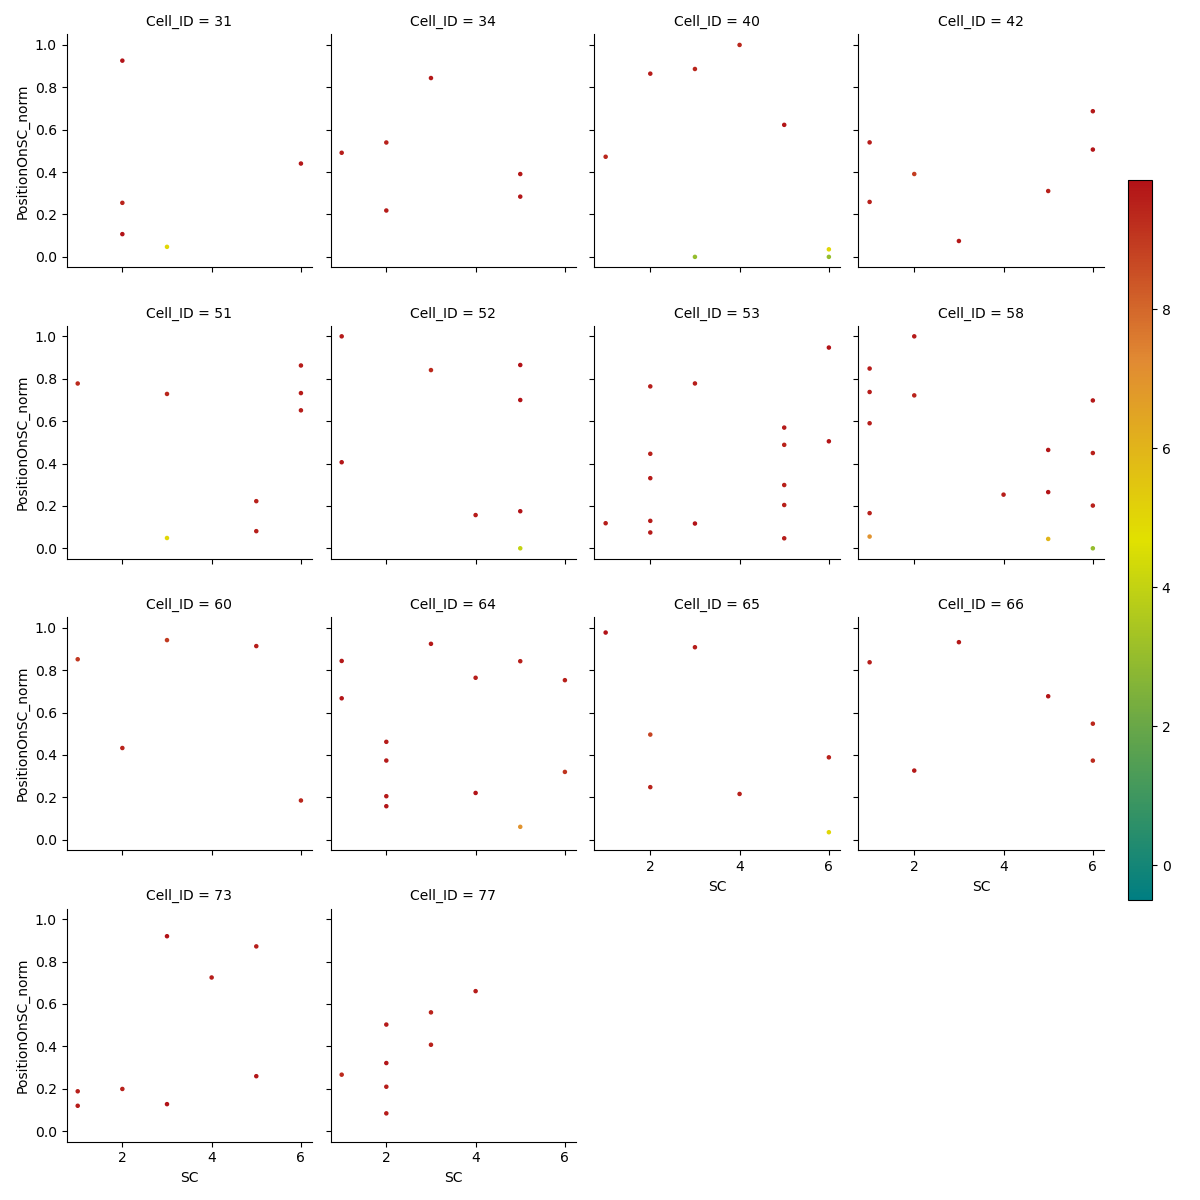

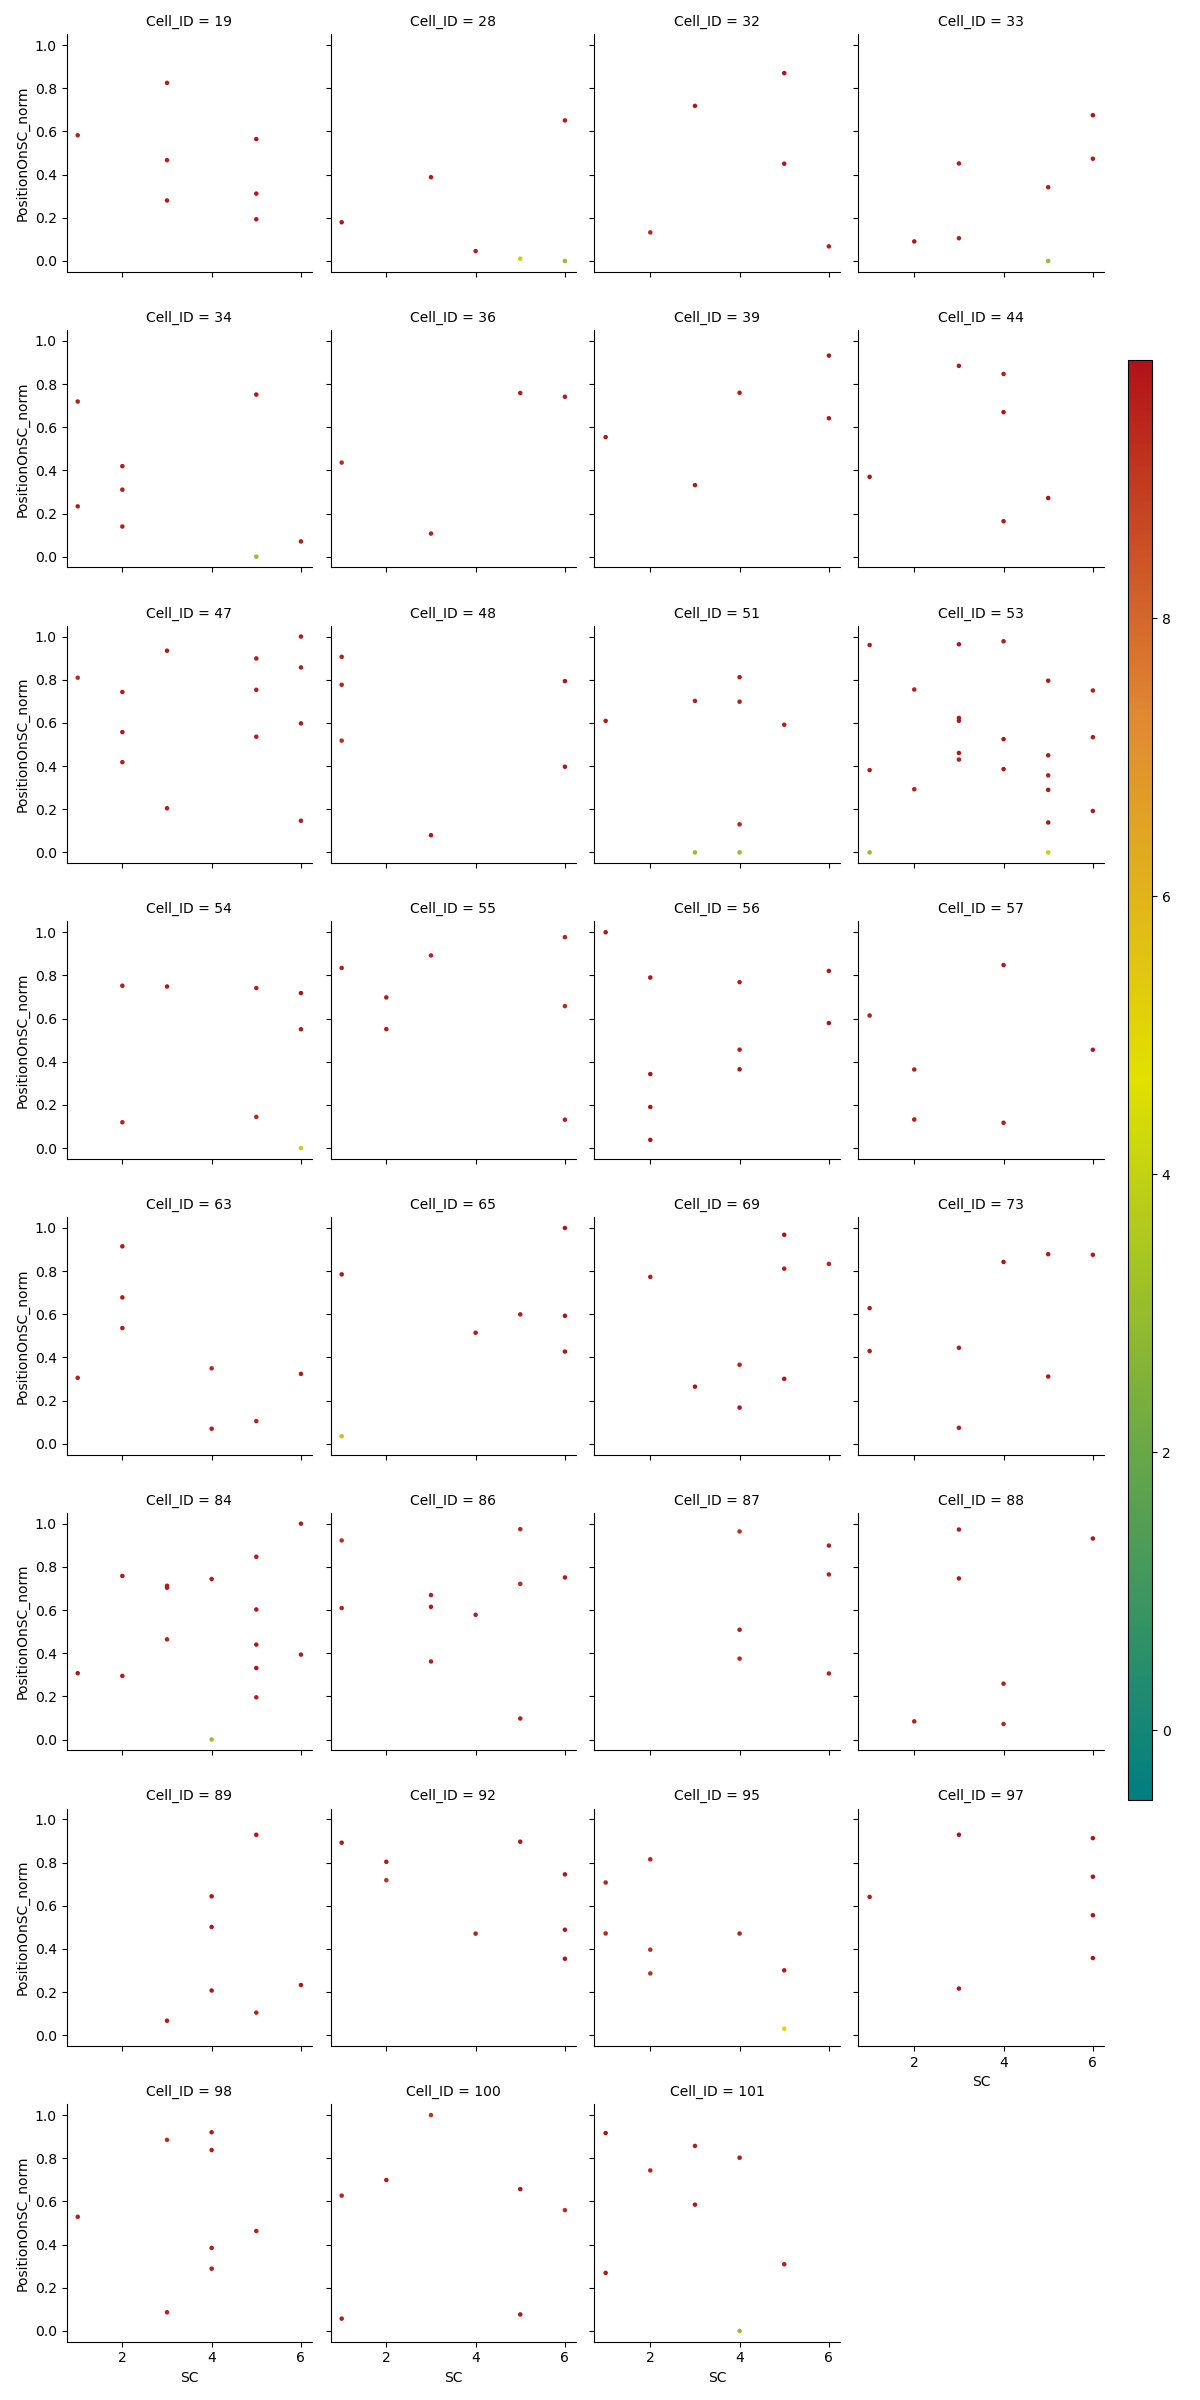

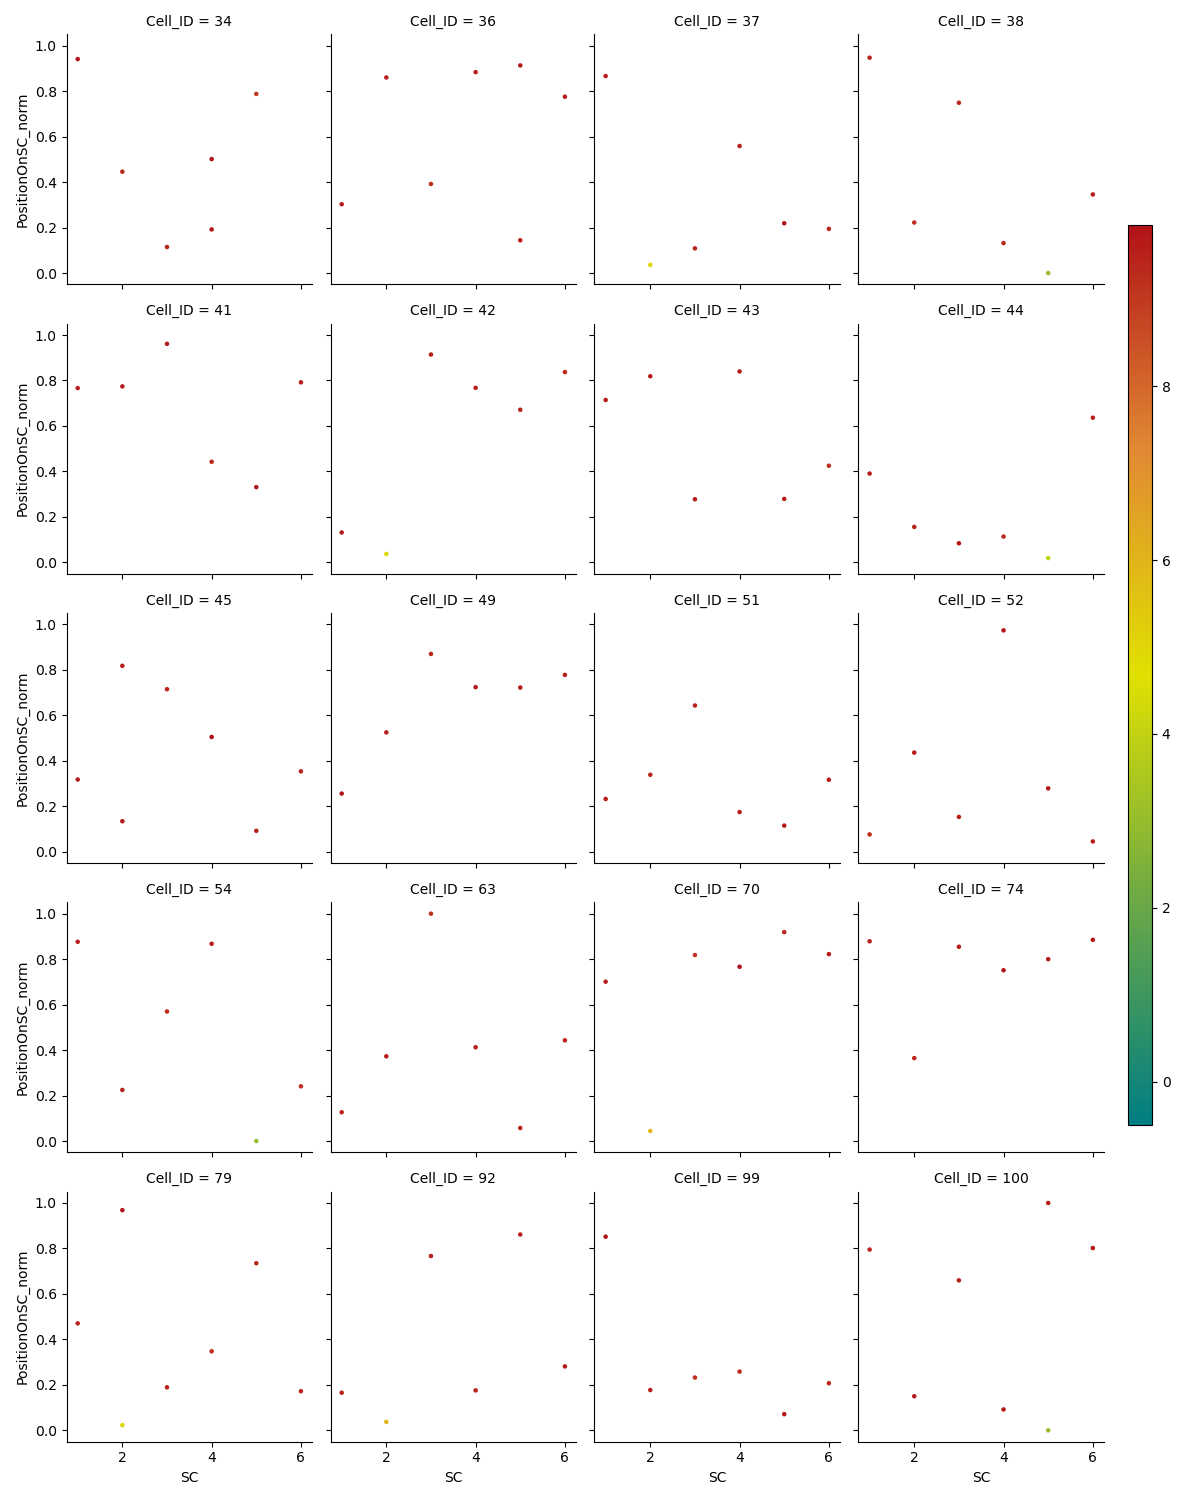

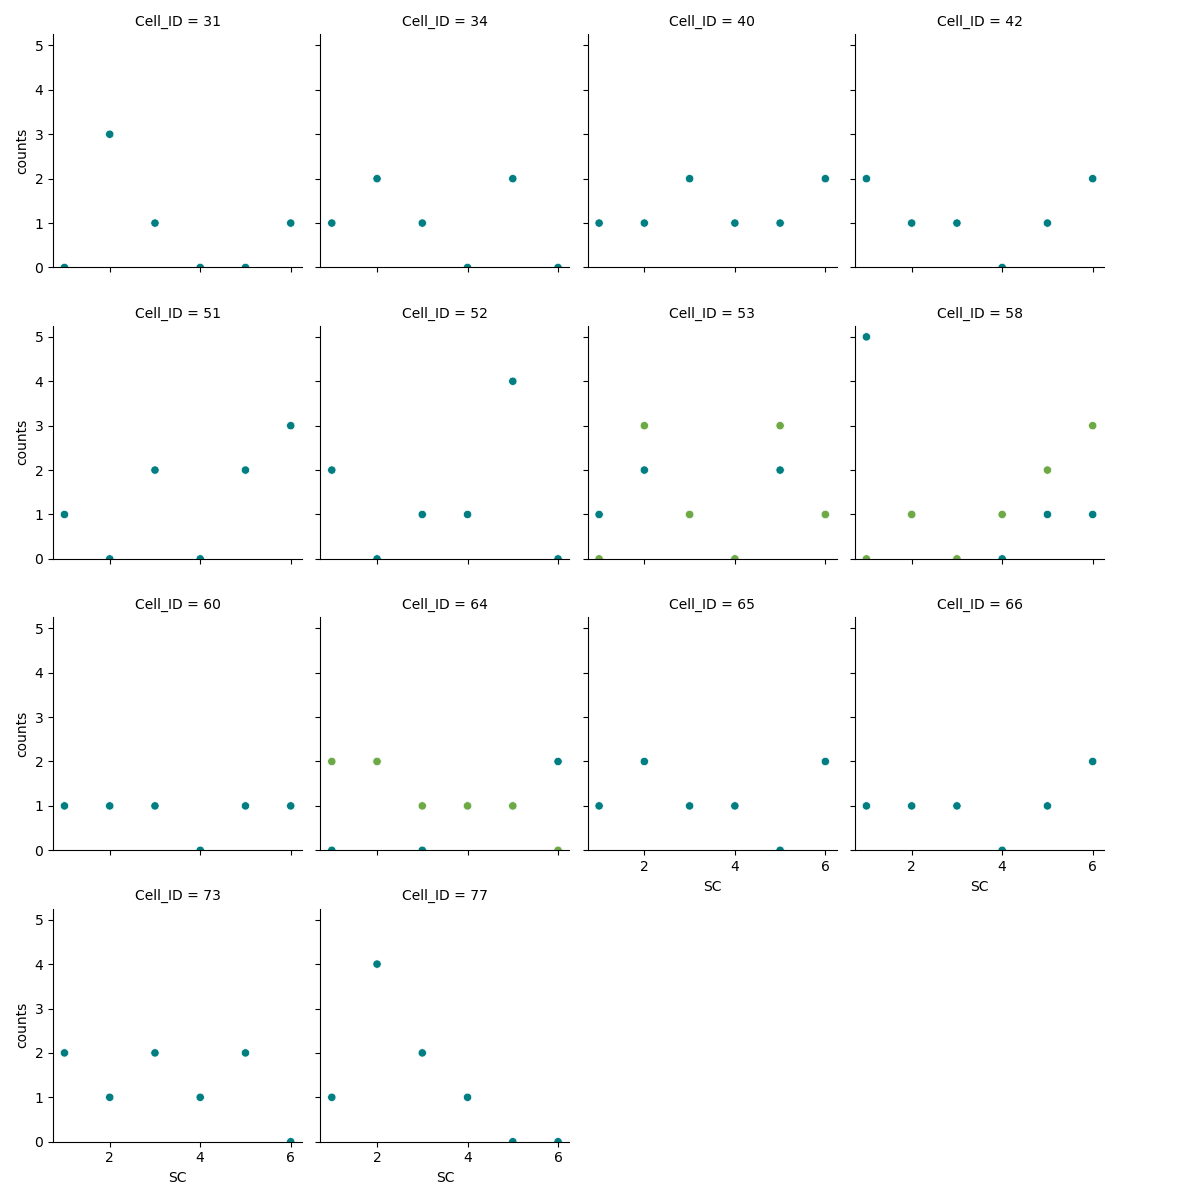

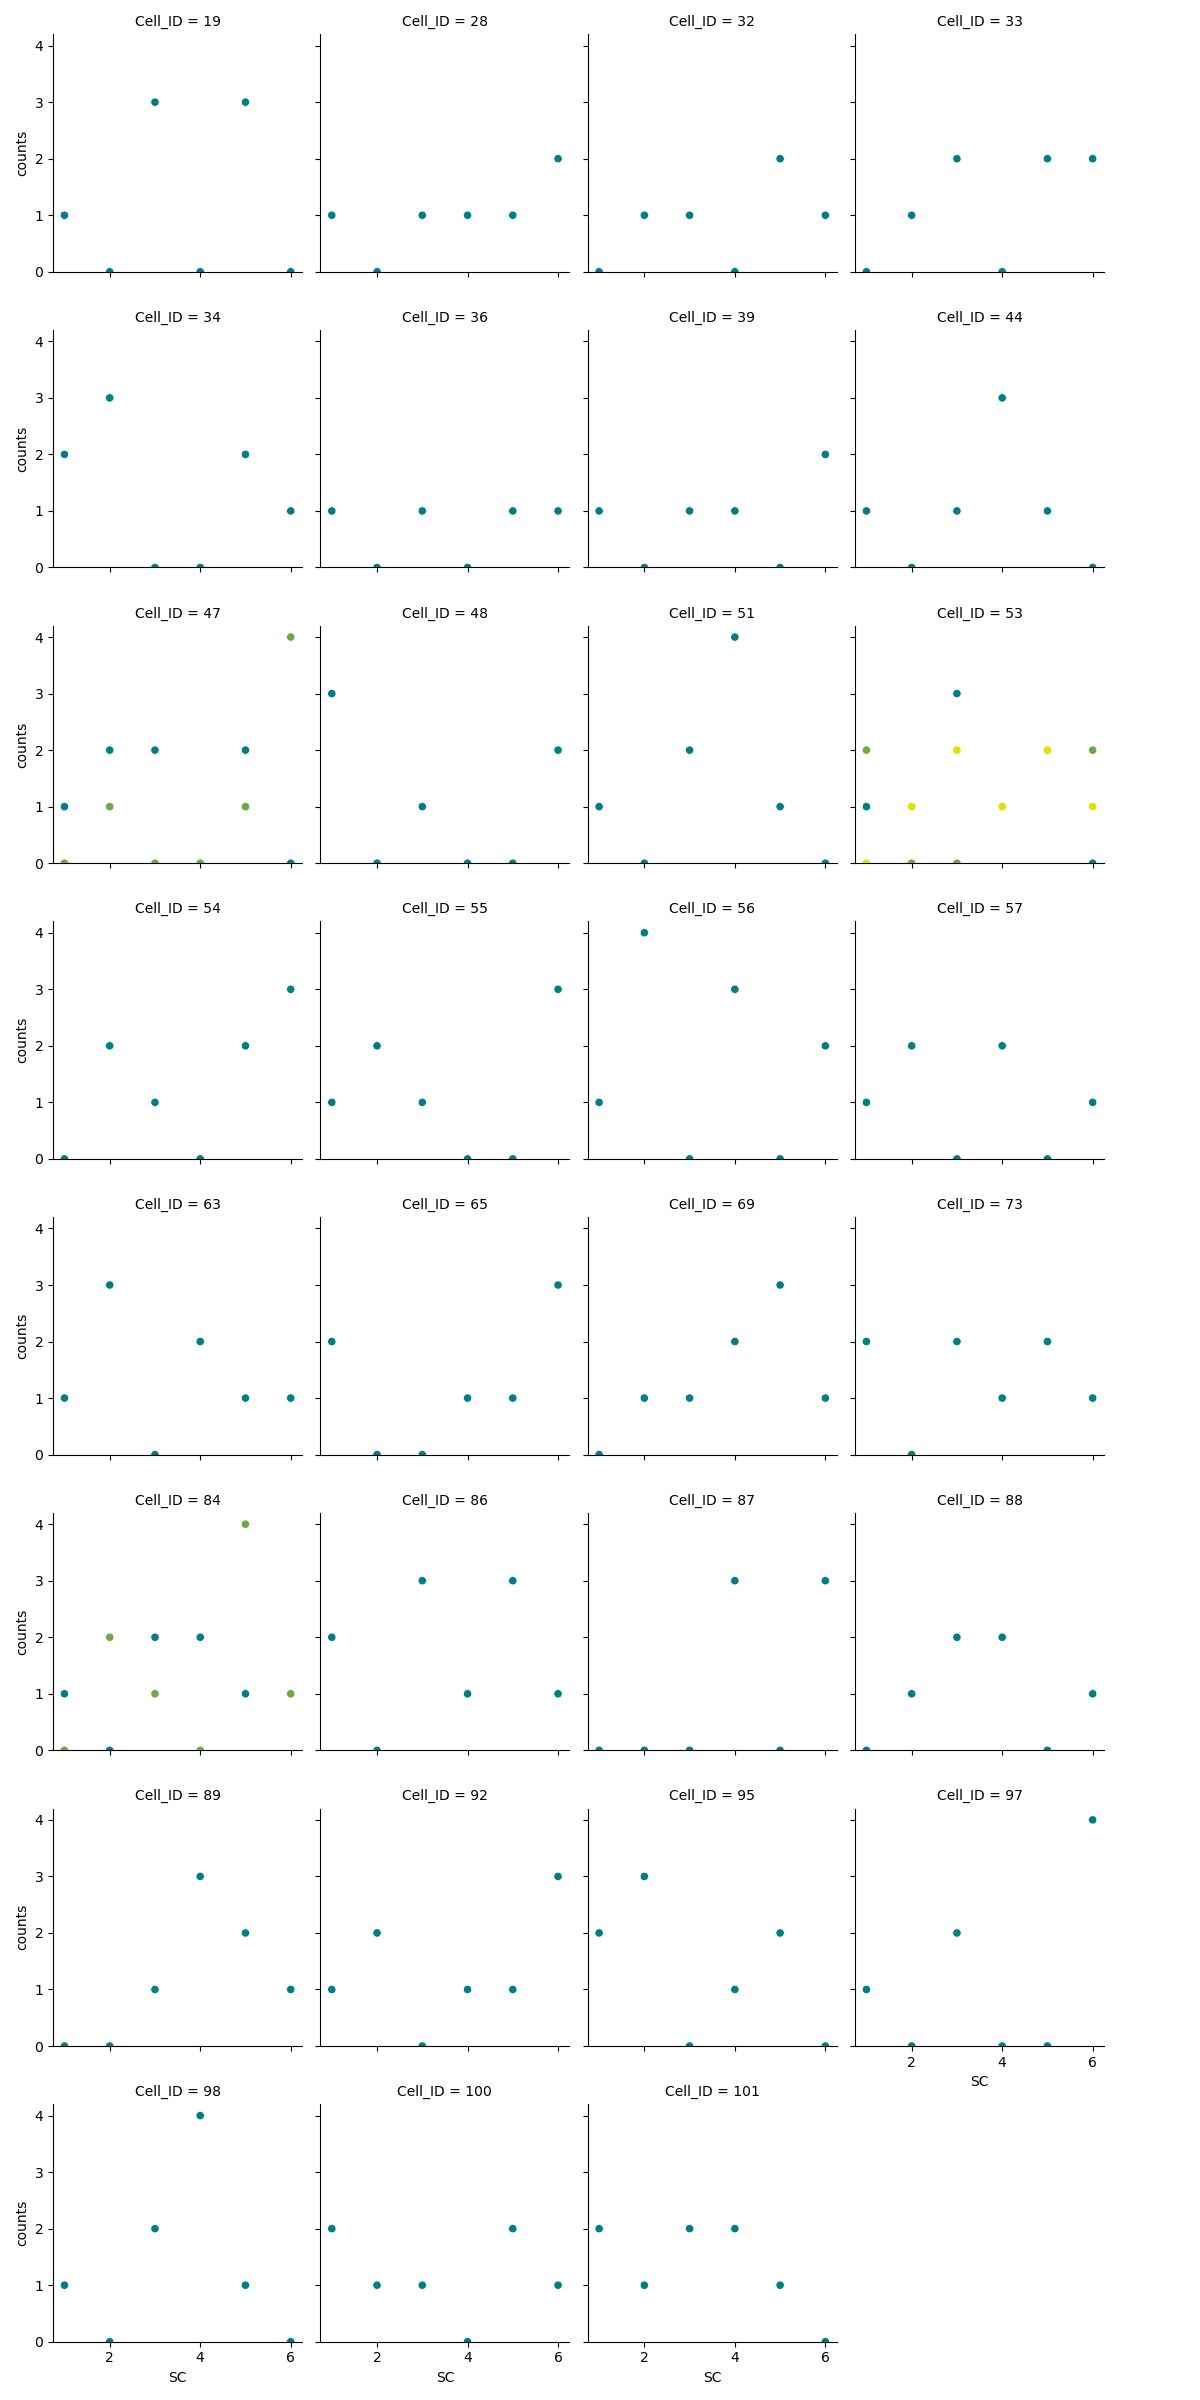

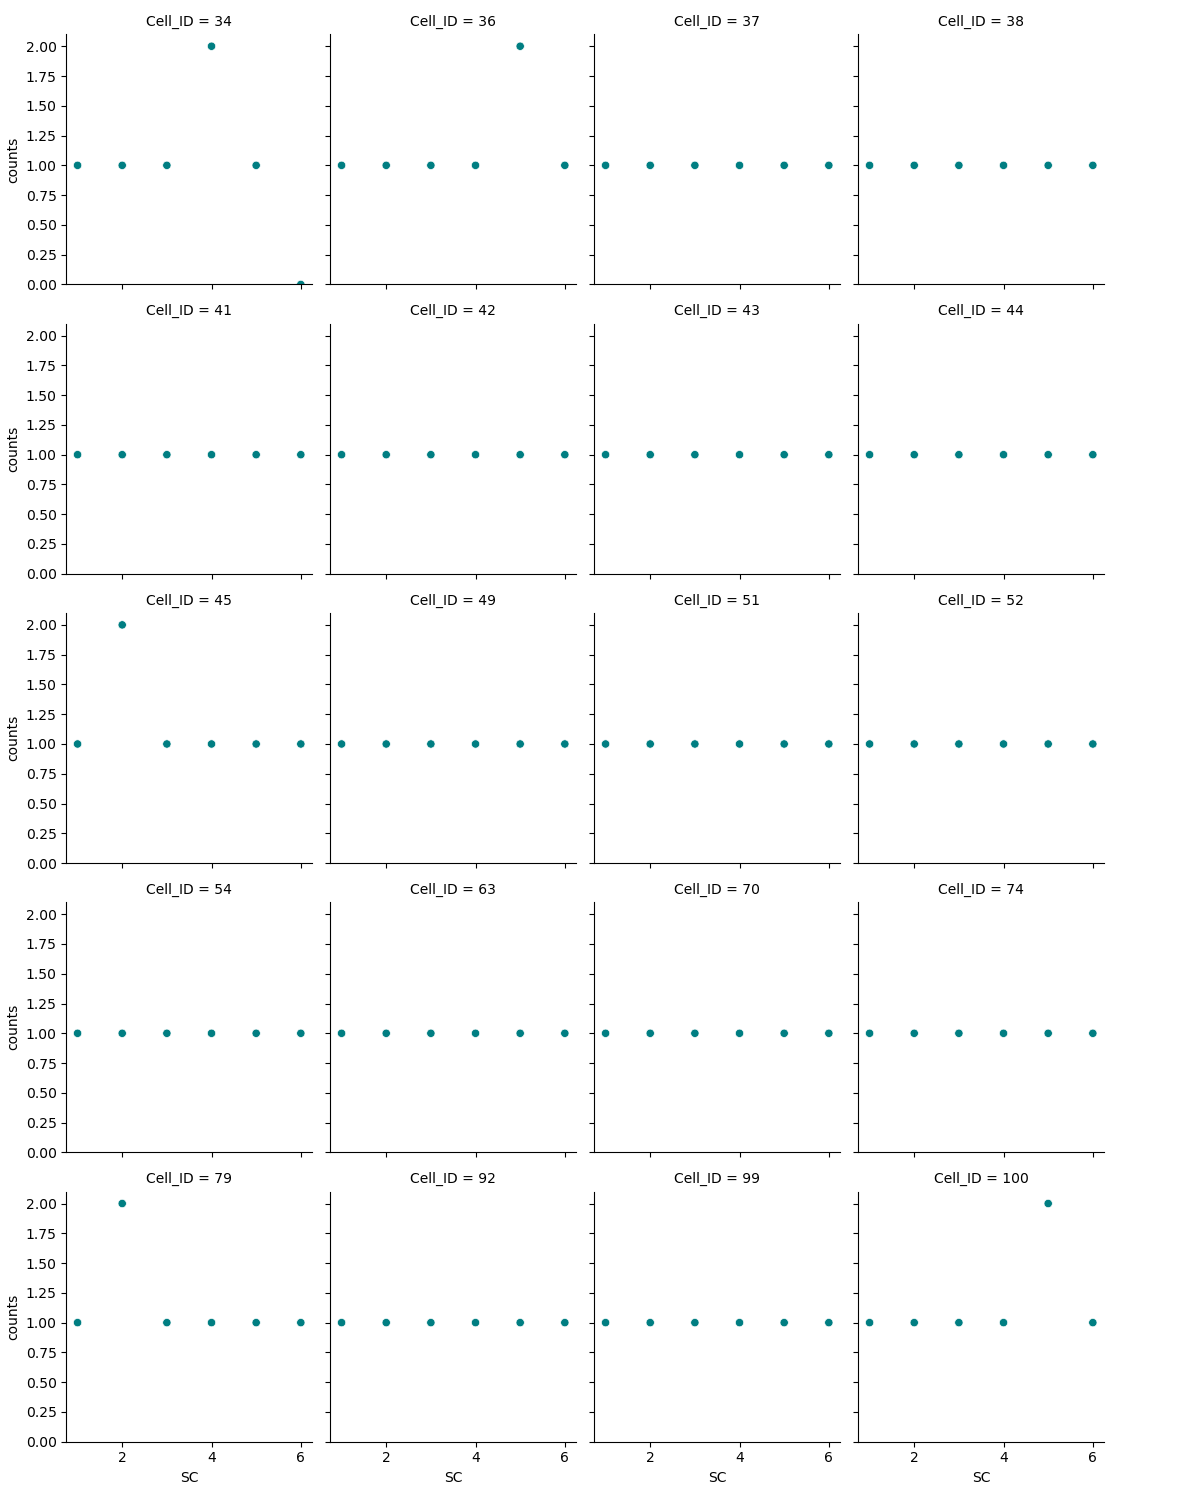

In [13]:
%matplotlib widget

for gt in np.unique(metadata_df["GT2"]):
    g = sns.FacetGrid(df_full[df_full["GT2_props"]==gt], col='Cell_ID', palette = 'PiYG',col_wrap=4)
    def facet_scatter(x, y, c, **kwargs):
        """Draw scatterplot with point colors from a faceted DataFrame columns."""
        kwargs.pop("color")
        plt.scatter(x, y, c=c, **kwargs)

    vmin, vmax =-.5, np.quantile(df_cosa_1_full["conf_of_loc_1"],0.95)
    colourby=df_full["conf_of_loc_1"],
    cmap = sns.blend_palette(ivana_col_main, n_colors=len(np.unique(colourby)), as_cmap=True, input='rgb')#sns.diverging_palette(220, 10,s=99, l=39,sep=6, center="dark", as_cmap=True)#choose_diverging_palette(as_cmap=False)#

    g = g.map(facet_scatter, 'SC', 'PositionOnSC_norm', "conf_of_loc_1", #PositionbyArclen
            s=5, vmin=vmin, vmax=vmax, cmap=cmap)

    # Make space for the colorbar
    g.fig.subplots_adjust(right=.92)

    # Define a new Axes where the colorbar will go
    cax = g.fig.add_axes([.94, .25, .02, .6])

    # Get a mappable object with the same colormap as the data
    points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax, cmap=cmap)

    # Draw the colorbar
    g.fig.colorbar(points, cax=cax)
    plt.show()
    if save_output:
        g.savefig(outPath+"/"+dt_string+begin_filename+"_"+additional_ending+"_"+gt+'_perTrace_position_conf_of_loc_1.pdf')

pallete_main={"color": ivana_col_main}
colourby=df_roistat["path"]
cmap = sns.color_palette(palette=ivana_col_main, n_colors=len(np.unique(colourby)), desat=None, as_cmap=True)
for gt in np.unique(metadata_df["GT2"]):
    zz=sns.FacetGrid(data=df_roistat[df_roistat["GT2"]==gt], col="Cell_ID",col_wrap=4)
    zz.map_dataframe(sns.scatterplot, x="SC", y="counts",hue="path", alpha = 1,palette=cmap)
    zz.fig.subplots_adjust(right=.92)
    zz.set(ylim=(0, None))
    plt.show()
    if save_output:
        zz.savefig(outPath+"/"+dt_string+begin_filename+"_"+additional_ending+"_"+gt+'_perTrace_counts.pdf')